# 1. Get data

In [50]:
import matplotlib.pyplot as plt
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib 
from tqdm import tqdm
matplotlib.rcParams['figure.figsize'] = [15, 5]


In [51]:
def get_test_logs(path:str, prefix:str, get_only_latest:bool):
    """get all test result filenames
    Args:
        path (str): path to test_cases
        prefix (str): prefix of log file
        get_only_latest (bool): if true return only latest file else return all files
    Returns:
        list of dicts, each dict corresponds for testcase 0-49
    """
    result_files = []
    test_dirs = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path,folder))]
    
    for challange in (test_dirs):
        kolvo_robotov = re.match(r'^(\d+)', challange).group(1)
        robot_challange_path= os.path.join(path,challange)
        test_cases = [folder for folder in os.listdir(robot_challange_path) if os.path.isdir(os.path.join(robot_challange_path,folder)) and (re.fullmatch(r"test_number\d+",folder) is not None)]
        
        for test in tqdm(test_cases):
            test_number = int(re.search(r'\d+$', test).group())
            test_dir = os.path.join(robot_challange_path,test)
            planner_generated_dirs = [ d for d in os.listdir(test_dir) if (prefix in d) and os.path.isdir(os.path.join(test_dir,d))]
            # print(os.listdir(test_dir))
            # break
            for planned_dir in (planner_generated_dirs):
                full_planned_dir = os.path.join(test_dir,planned_dir)
                seed =  int(re.search(r'\d+$', planned_dir).group())
                if "robot_trajectories.json" not in os.listdir(full_planned_dir):
                    continue
                try:
                    with open(os.path.join(full_planned_dir,"robot_trajectories.json"),'r') as f:
                        data_traj = json.load(f)
                except json.JSONDecodeError as e:
                    print(e)
                    print(full_planned_dir)
                    continue
                result = False
                error = ""
                if isinstance(data_traj[-1],dict):
                    if "result" in data_traj[-1]:
                        result = data_traj[-1]["result"]
                    elif "error" in data_traj[-1]:
                        error = data_traj[-1]["error"]
                        if "result" in data_traj[-2]:
                            result = data_traj[-2]["result"]
                        else:
                            print(full_planned_dir)
                            print(data_traj[-1])
                    else:
                        print(full_planned_dir)
                        print(data_traj[-1])
                else:
                    print(full_planned_dir)
                    print(data_traj[-1])
                logs = [ d for d in os.listdir(full_planned_dir) if ("planner_logs" in d)]
                one_test_result_files = []
                for log in logs:
                    
                    pattern = r'start_time_(\d+\.\d+).*?planner_logs_(\d+).*?robot_number_(\d+).json$'
                    match = re.search(pattern, log)
                    if not match:
                        print(full_planned_dir,log)
                        continue
                    assert(match)
                    start_time = match.group(1)
                    timestamp = match.group(2)
                    robot_number = match.group(3)
                    log_path = os.path.join(full_planned_dir,log)
                    try:
                        with open(log_path,'r') as f:
                            data = json.load(f)
                    except json.JSONDecodeError as e:
                        print(e)
                        print(log_path)
                        continue
                    if not data["final_planner_data"]["has_result"]:
                        continue
                    data["final_planner_data"].pop("final_path")
                    
                    one_test_result_files.append({
                    "start_time":float(start_time),
                    "timestamp": int(timestamp),
                    "robot_number":int(robot_number),
                    "data":data,
                    "file_path":log_path
                })
                    
                result_files.append({
                    "test_case_id":int(test_number),
                    "kolvo_robotob":kolvo_robotov,
                    "success":result,
                    "dir_path":planned_dir,
                    "seed":seed,
                    "error":error,
                    "planning_instances":one_test_result_files
                    # "robot_trajectories":data_traj,
                })
    return result_files


In [52]:
test_dir = "../multiagent_tests"
msirrt_test_files = get_test_logs(path = test_dir,prefix = "msirrt", get_only_latest = False)

100%|██████████| 25/25 [00:00<00:00, 351.39it/s]


In [53]:
# with open("MSIRRT_multiagent_results.json",'w') as f:
#     json.dump(msirrt_test_files,f)

In [54]:
# with open("MSIRRT_multiagent_results.json",'r') as f:
#     msirrt_test_files = json.load(f)

In [55]:
test_dir = "../multiagent_tests"
strrt_test_files = get_test_logs(path = test_dir,prefix = "strrt", get_only_latest = False)


100%|██████████| 25/25 [00:00<00:00, 258.72it/s]


In [56]:
# with open("STRRT_multiagent_results.json",'w') as f:
#     json.dump(strrt_test_files,f)

In [57]:
# with open("STRRT_multiagent_results.json",'r') as f:
#     strrt_test_files = json.load(f)

# Execution Time

In [69]:
comparison.head()

Empty DataFrame
Columns: [planner_sirrt, test_id, num_robots, success_sirrt, seed, robot_number, start_time_sirrt, has_result_sirrt, path_cost_sirrt, algorithm_solving_time_ns_sirrt, collision_check_time_ns_sirrt, number_of_collision_checks_sirrt, full_execution_time_ns_sirrt, number_of_vertices_sirrt, number_of_edges_sirrt, planner_strrt, success_strrt, start_time_strrt, has_result_strrt, path_cost_strrt, algorithm_solving_time_ns_strrt, collision_check_time_ns_strrt, number_of_collision_checks_strrt, full_execution_time_ns_strrt, number_of_vertices_strrt, number_of_edges_strrt, time_ratio]
Index: []

[0 rows x 27 columns]

In [58]:
sirrt_res = msirrt_test_files
strrt_res = strrt_test_files

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract data from the results
def extract_data(results):
    data = []
    
    for planner_name, planner_results in results:
        print(planner_name)
        for test_result in planner_results:
            test_id = test_result['test_case_id']
            num_robots = int(test_result['kolvo_robotob'])
            success = test_result['success']
            seed = test_result['seed']
            
            # Extract planning instances data
            for instance in test_result['planning_instances']:
                robot_num = instance['robot_number']
                start_time = instance['start_time']
                
                # Extract metrics from data
                instance_data = instance['data']
                
                data.append({
                    'planner': planner_name,
                    'test_id': test_id,
                    'num_robots': num_robots,
                    'success': success,
                    'seed': seed,
                    'robot_number': robot_num,
                    'start_time': start_time,
                    'has_result': instance_data['final_planner_data']['has_result'],
                    'path_cost': instance_data['final_planner_data'].get('path_cost', np.nan),
                    'algorithm_solving_time_ns': instance_data['algorithm_solving_time_ns'],
                    'collision_check_time_ns': instance_data['collision_check_time_ns'],
                    'number_of_collision_checks': instance_data['number_of_collision_checks'],
                    'full_execution_time_ns': instance_data['full_execution_time_ns'],
                    'number_of_vertices': instance_data['final_planner_data'].get('number_of_vertices', 0),
                    'number_of_edges': instance_data['final_planner_data'].get('number_of_edges', 0)
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = extract_data([('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)])


SI-RRT
ST-RRT*


In [72]:
# Create a comparison dataframe by merging SI-RRT and ST-RRT* data on matching test configurations
sirrt_data = df[df['planner'] == 'SI-RRT'].copy()
strrt_data = df[df['planner'] == 'ST-RRT*'].copy()

# Merge on test configuration to compare same scenarios
comparison = sirrt_data.merge(
    strrt_data, 
    on=['test_id', 'num_robots', 'robot_number'], 
    suffixes=('_sirrt', '_strrt')
)

# Calculate the ratio of SI-RRT to ST-RRT* solving time
comparison['time_ratio'] =  comparison['algorithm_solving_time_ns_strrt']/comparison['algorithm_solving_time_ns_sirrt'] 

# Filter for instances where SI-RRT is significantly slower (e.g., 3x or more)
threshold = 100
slow_instances = comparison[comparison['time_ratio'] >= threshold].copy()

# Sort by time ratio (highest ratios first)
slow_instances = slow_instances.sort_values('time_ratio', ascending=False)

print(f"Instances where SI-RRT is {threshold}x or more slower than ST-RRT*:")
print("=" * 80)

for idx, row in slow_instances.iterrows():
    print(f"Test ID: {row['test_id']}, Num Robots: {row['num_robots']}")
    print(f"Robot Number: {row['robot_number']}, Start Time: {row['start_time_sirrt']:.2f}")
    print(f"SI-RRT Time: {row['algorithm_solving_time_ns_sirrt']/1e6:.2f}ms")
    print(f"ST-RRT* Time: {row['algorithm_solving_time_ns_strrt']/1e6:.2f}ms")
    print(f"Ratio: {row['time_ratio']:.2f}x")
    print("-" * 40)

print(f"\nTotal instances found: {len(slow_instances)}")

# Show summary statistics
print(f"\nSummary by number of robots:")
summary = slow_instances.groupby('num_robots').agg({
    'time_ratio': ['count', 'mean', 'max'],
    'algorithm_solving_time_ns_sirrt': lambda x: np.mean(x)/1e6,
    'algorithm_solving_time_ns_strrt': lambda x: np.mean(x)/1e6
}).round(2)

print(summary)

Instances where SI-RRT is 100x or more slower than ST-RRT*:
Test ID: 7, Num Robots: 6
Robot Number: 1, Start Time: 32.66
SI-RRT Time: 0.33ms
ST-RRT* Time: 8855.18ms
Ratio: 26513.22x
----------------------------------------
Test ID: 7, Num Robots: 6
Robot Number: 1, Start Time: 61.41
SI-RRT Time: 0.37ms
ST-RRT* Time: 8855.18ms
Ratio: 23626.28x
----------------------------------------
Test ID: 7, Num Robots: 6
Robot Number: 1, Start Time: 30.46
SI-RRT Time: 0.38ms
ST-RRT* Time: 8855.18ms
Ratio: 23221.03x
----------------------------------------
Test ID: 7, Num Robots: 6
Robot Number: 1, Start Time: 56.32
SI-RRT Time: 0.50ms
ST-RRT* Time: 8855.18ms
Ratio: 17767.35x
----------------------------------------
Test ID: 16, Num Robots: 8
Robot Number: 7, Start Time: 69.79
SI-RRT Time: 0.29ms
ST-RRT* Time: 4619.32ms
Ratio: 15679.99x
----------------------------------------
Test ID: 16, Num Robots: 8
Robot Number: 7, Start Time: 74.63
SI-RRT Time: 0.34ms
ST-RRT* Time: 4619.32ms
Ratio: 13761.10x
-

/tmp/ipykernel_229244/415301564.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


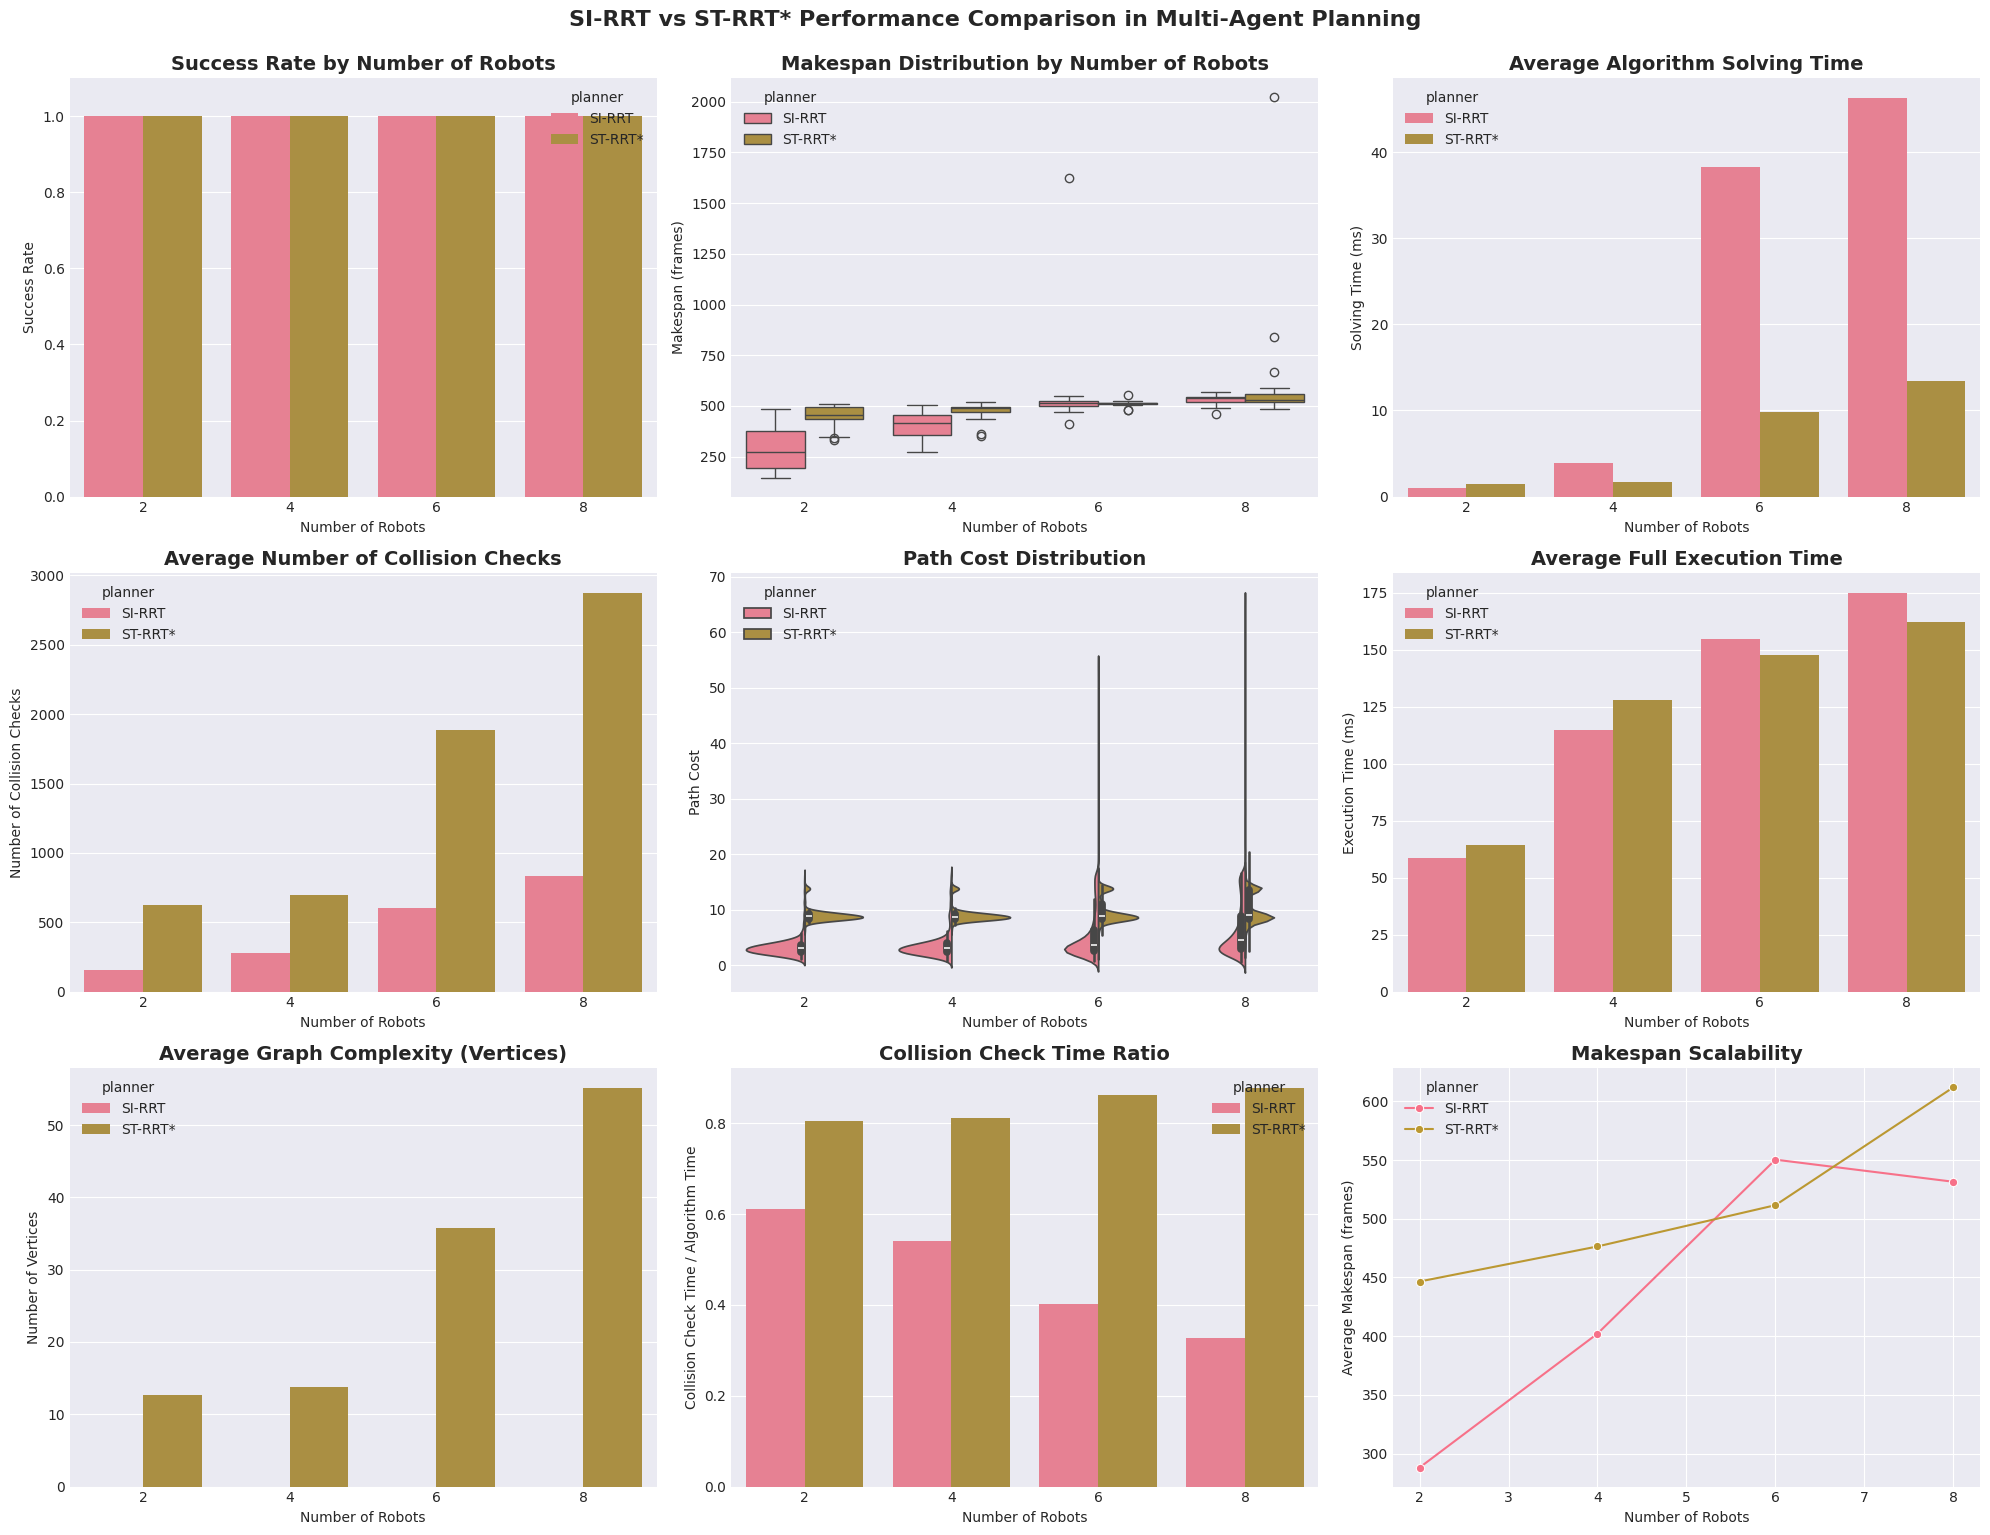

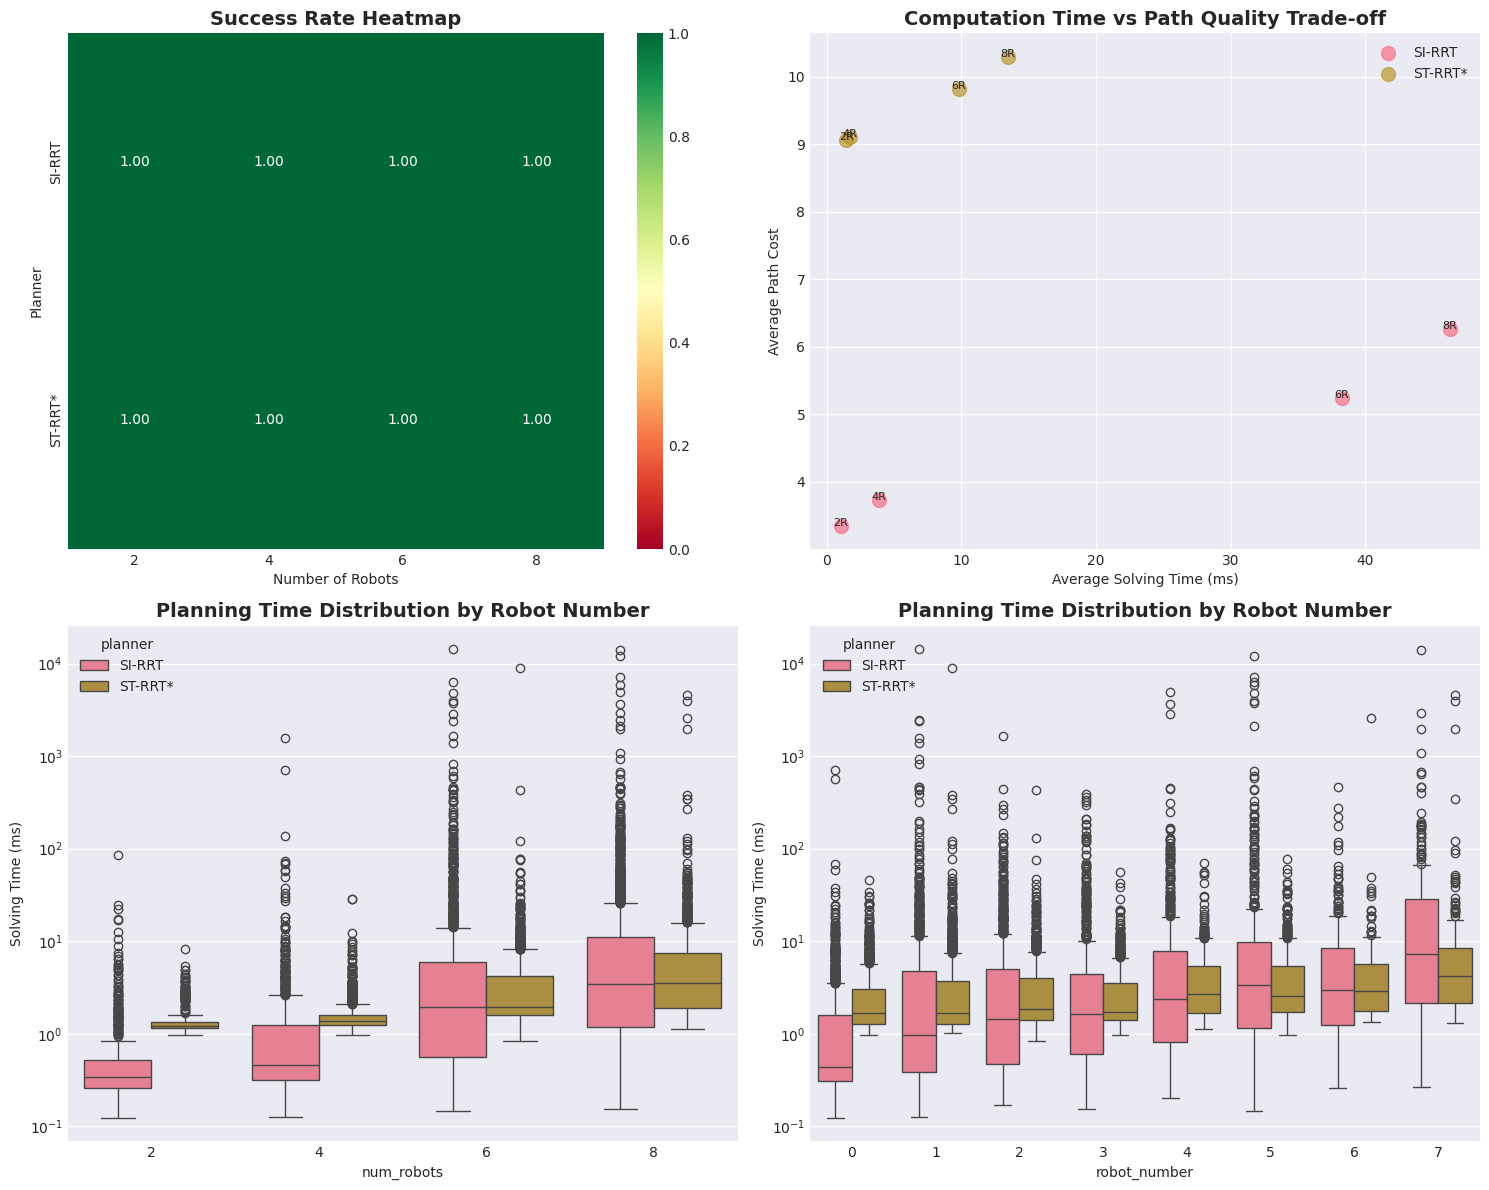

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      1.0
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  2           288.10  105.47
        4           402.15   69.05
        6           550.32  225.04
        8           531.49   25.51
ST-RRT* 2           446.55   54.02
        4           476.40   40.79
        6           511.54   13.31
        8           611.90  308.88


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2              1.04
         4              3.90
         6             38.25
         8             46.27
ST-RRT*  2              1.45
         4              1.71
         6              9.83
         8             13.44
Name: algorithm_solving_time_ns, dtype: fl

In [47]:

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('num_robots')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax4)
ax4.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax4.set_xlabel('robot_number')
ax4.set_ylabel('Solving Time (ms)')
ax4.set_yscale('log')


plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_229244/415301564.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


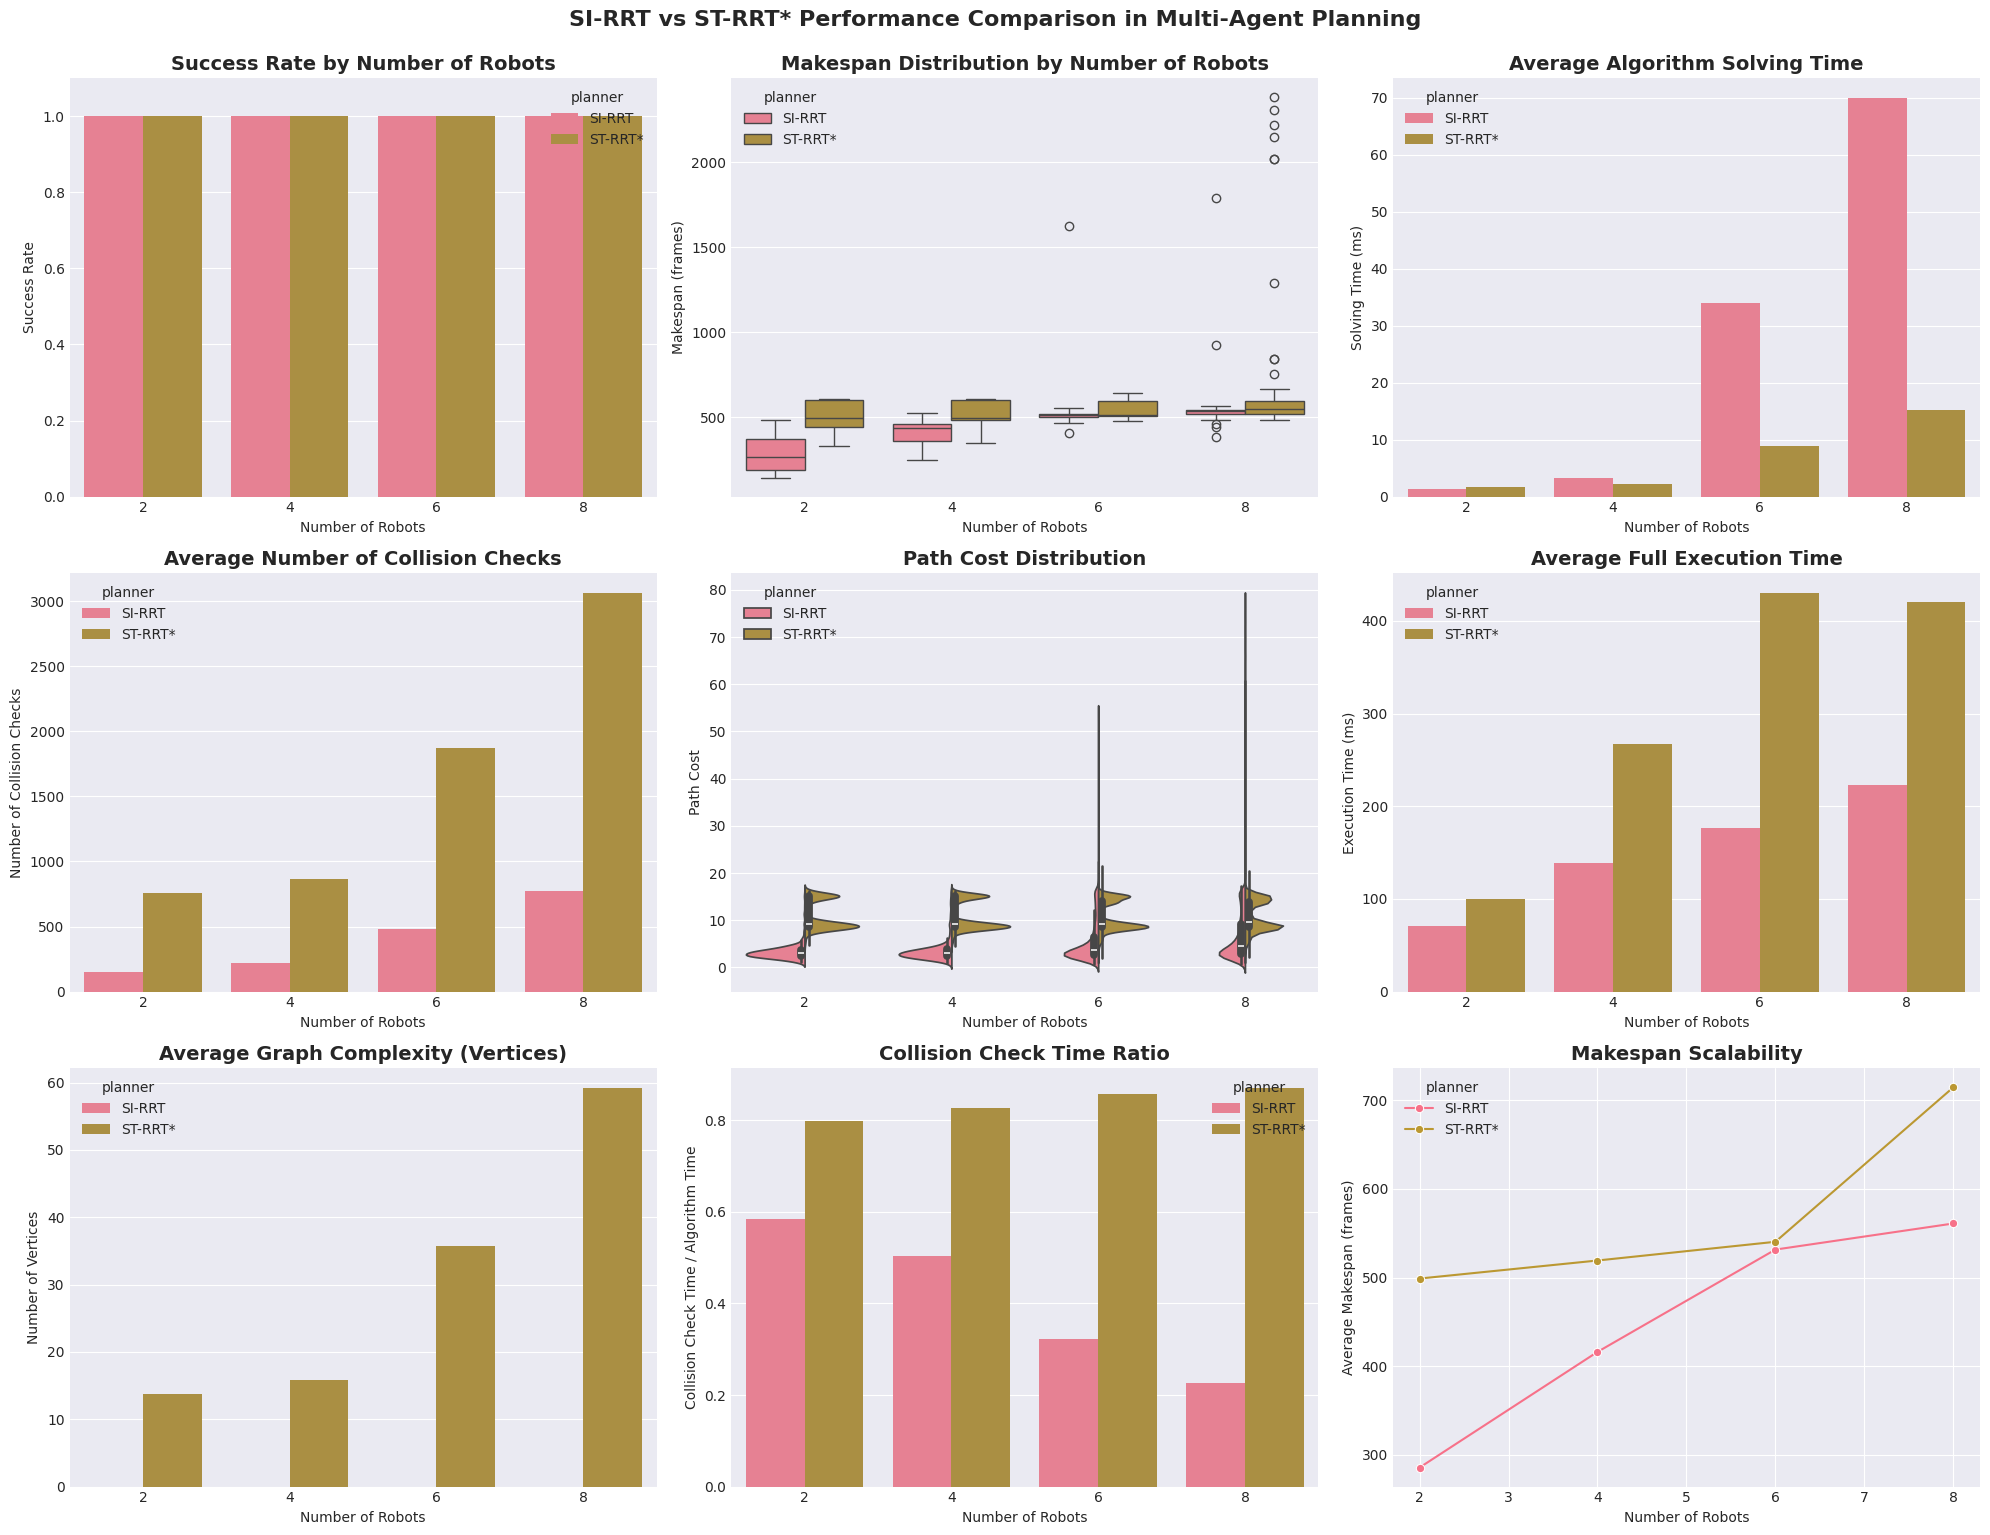

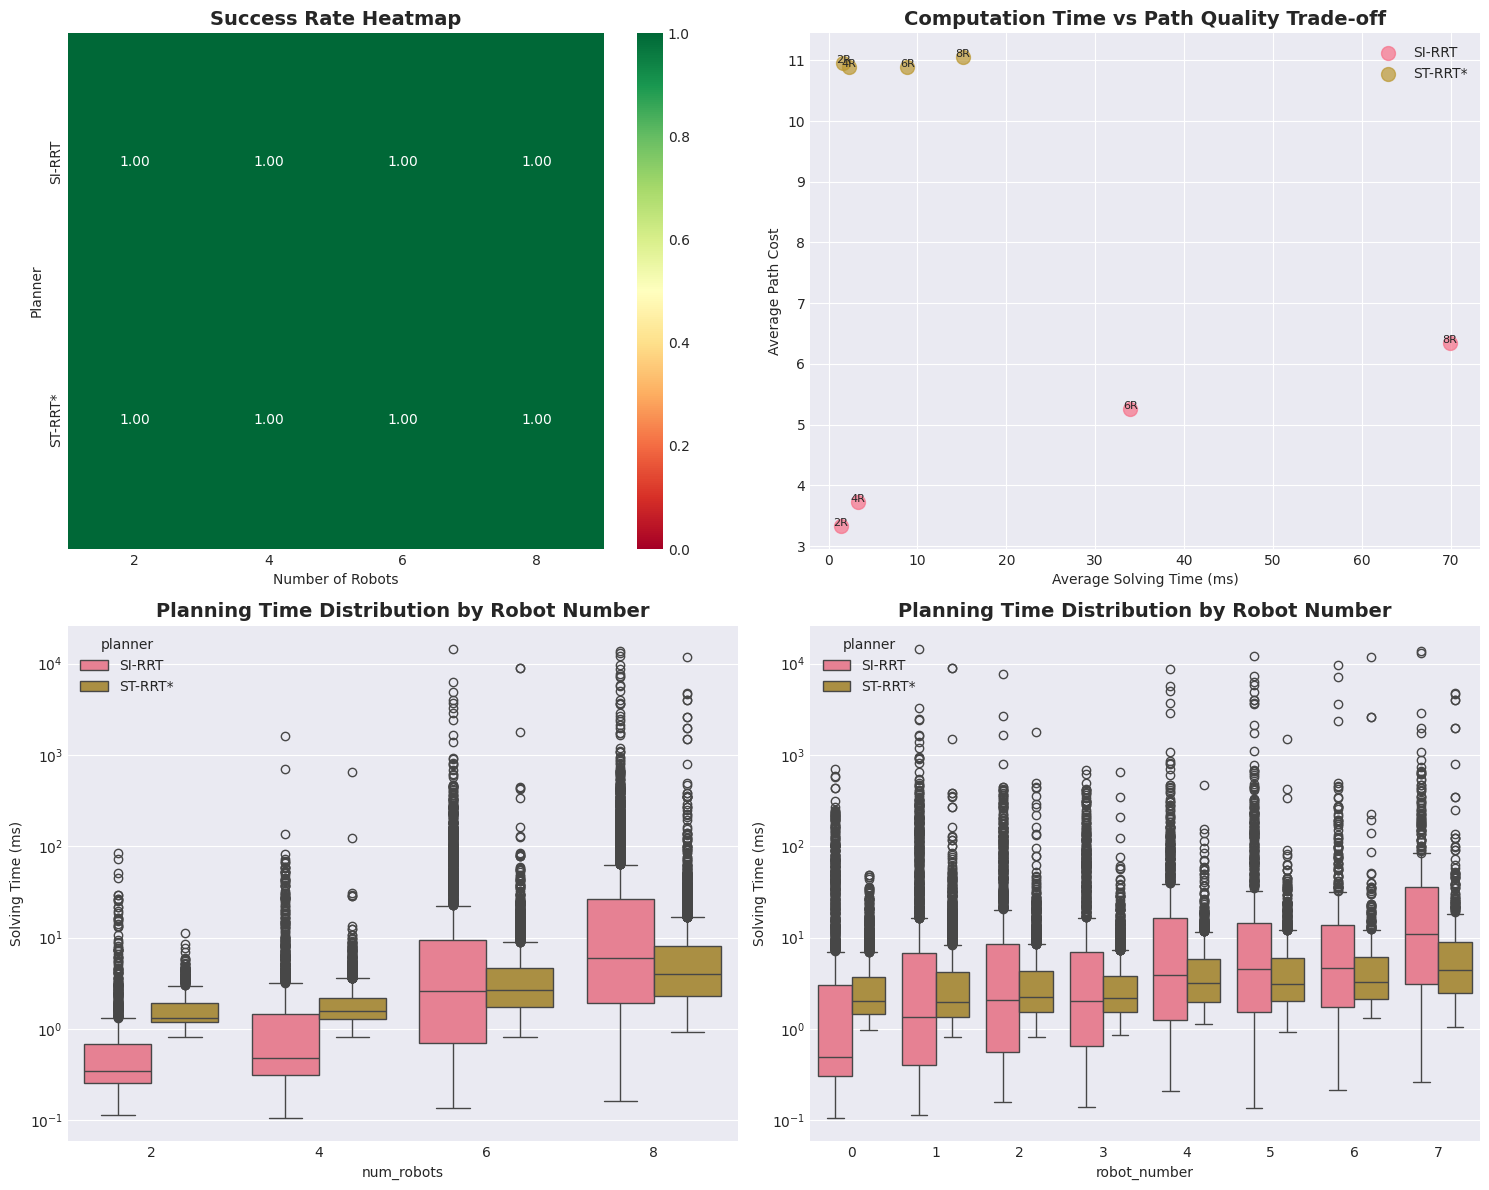

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      1.0
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  2           285.67  102.93
        4           416.15   72.82
        6           531.59  158.96
        8           561.02  191.16
ST-RRT* 2           498.91   86.36
        4           519.26   69.30
        6           540.39   43.69
        8           714.61  467.79


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2              1.34
         4              3.30
         6             33.96
         8             69.89
ST-RRT*  2              1.65
         4              2.27
         6              8.85
         8             15.14
Name: algorithm_solving_time_ns, dtype: fl

In [13]:

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('num_robots')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax4)
ax4.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax4.set_xlabel('robot_number')
ax4.set_ylabel('Solving Time (ms)')
ax4.set_yscale('log')


plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_2498/415301564.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


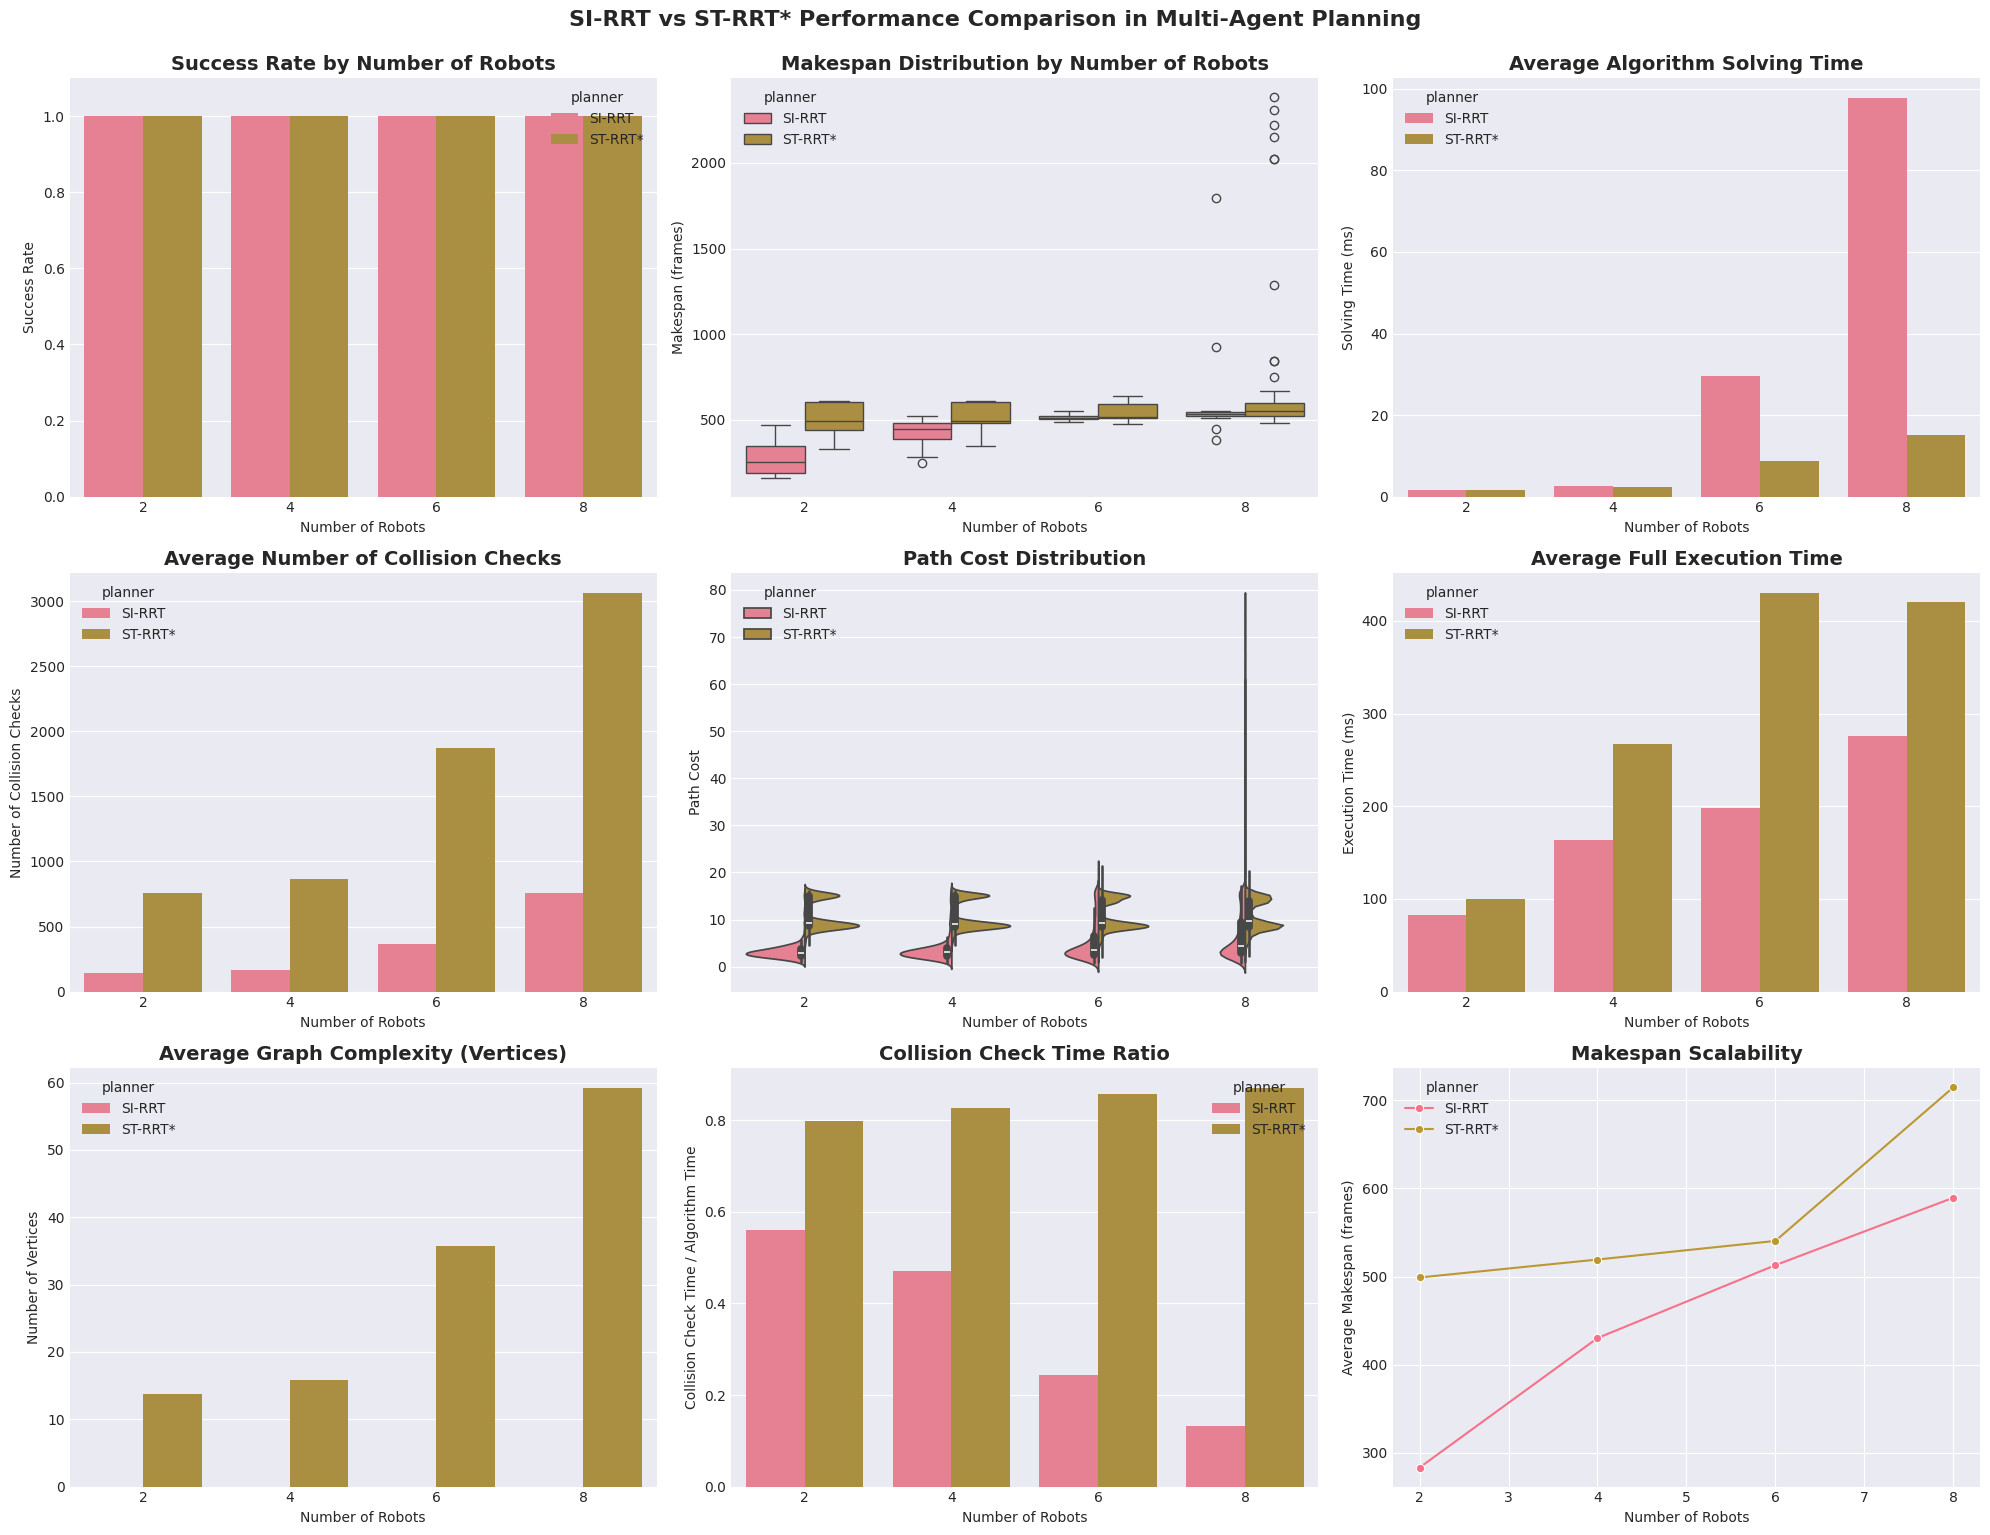

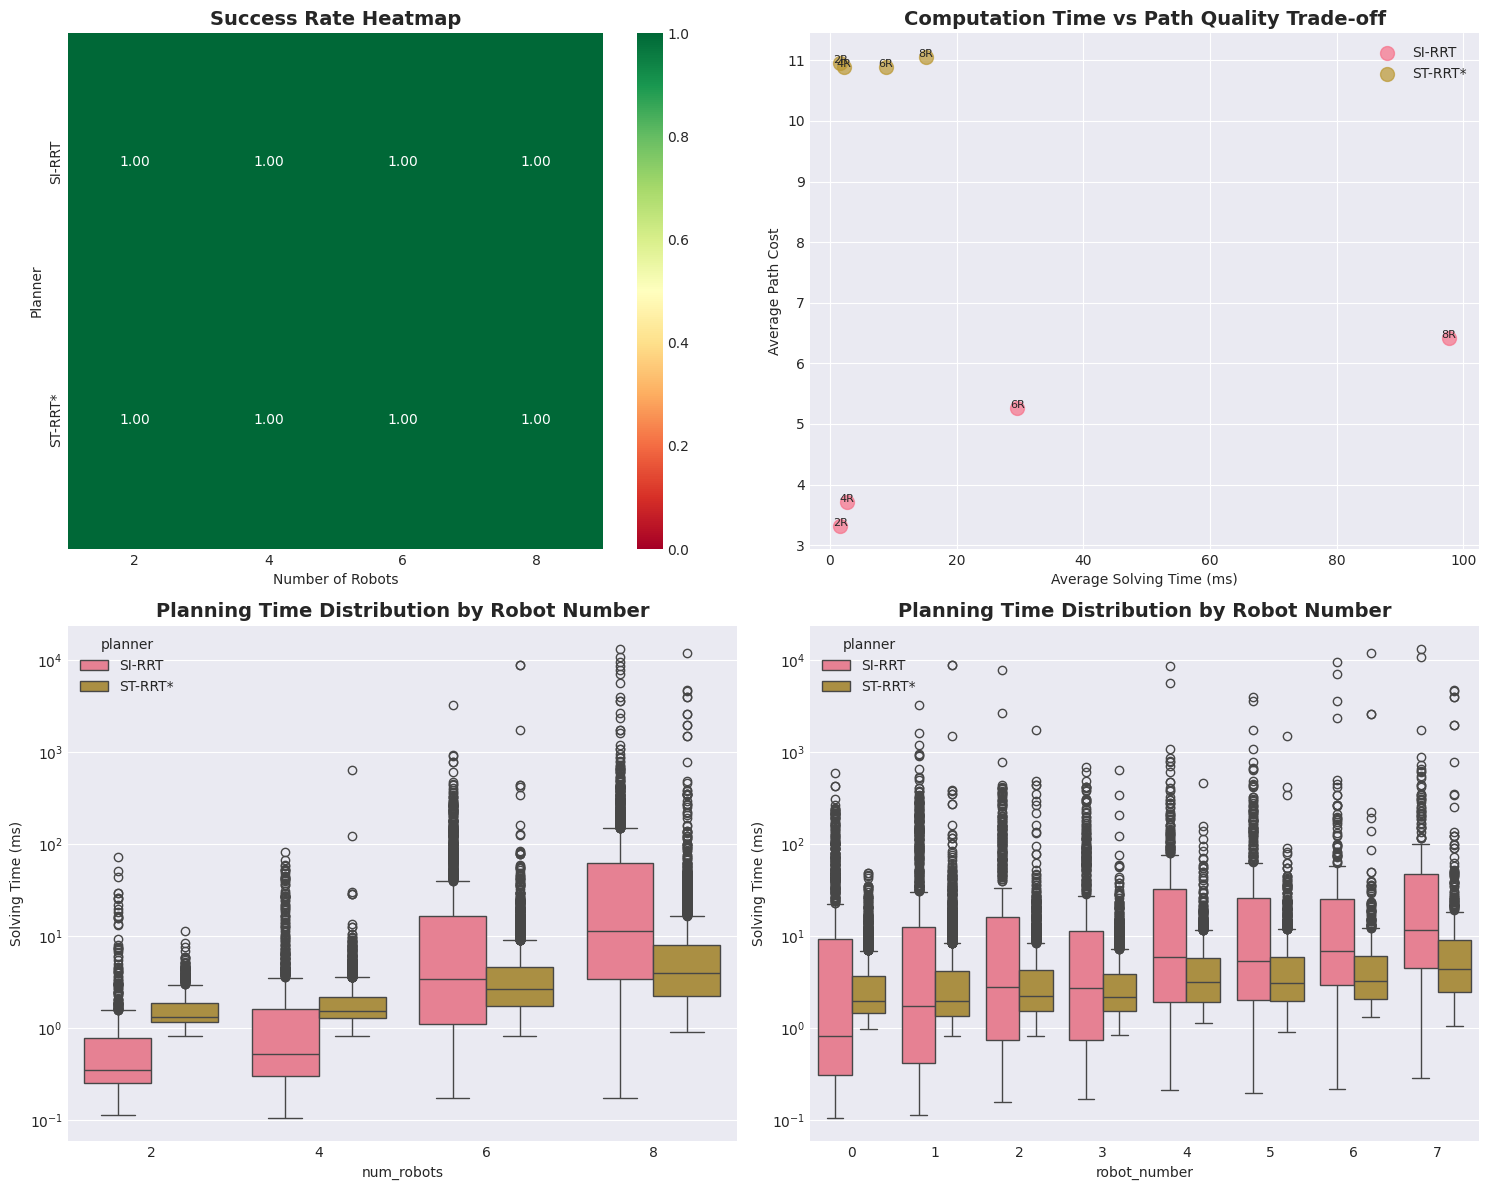

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      1.0
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  2           283.24  102.43
        4           430.15   75.18
        6           512.85   14.84
        8           589.37  265.99
ST-RRT* 2           498.91   86.36
        4           519.26   69.30
        6           540.39   43.69
        8           714.61  467.79


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2              1.63
         4              2.67
         6             29.59
         8             97.71
ST-RRT*  2              1.65
         4              2.27
         6              8.85
         8             15.14
Name: algorithm_solving_time_ns, dtype: fl

In [115]:

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('num_robots')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax4)
ax4.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax4.set_xlabel('robot_number')
ax4.set_ylabel('Solving Time (ms)')
ax4.set_yscale('log')


plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_2498/415301564.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


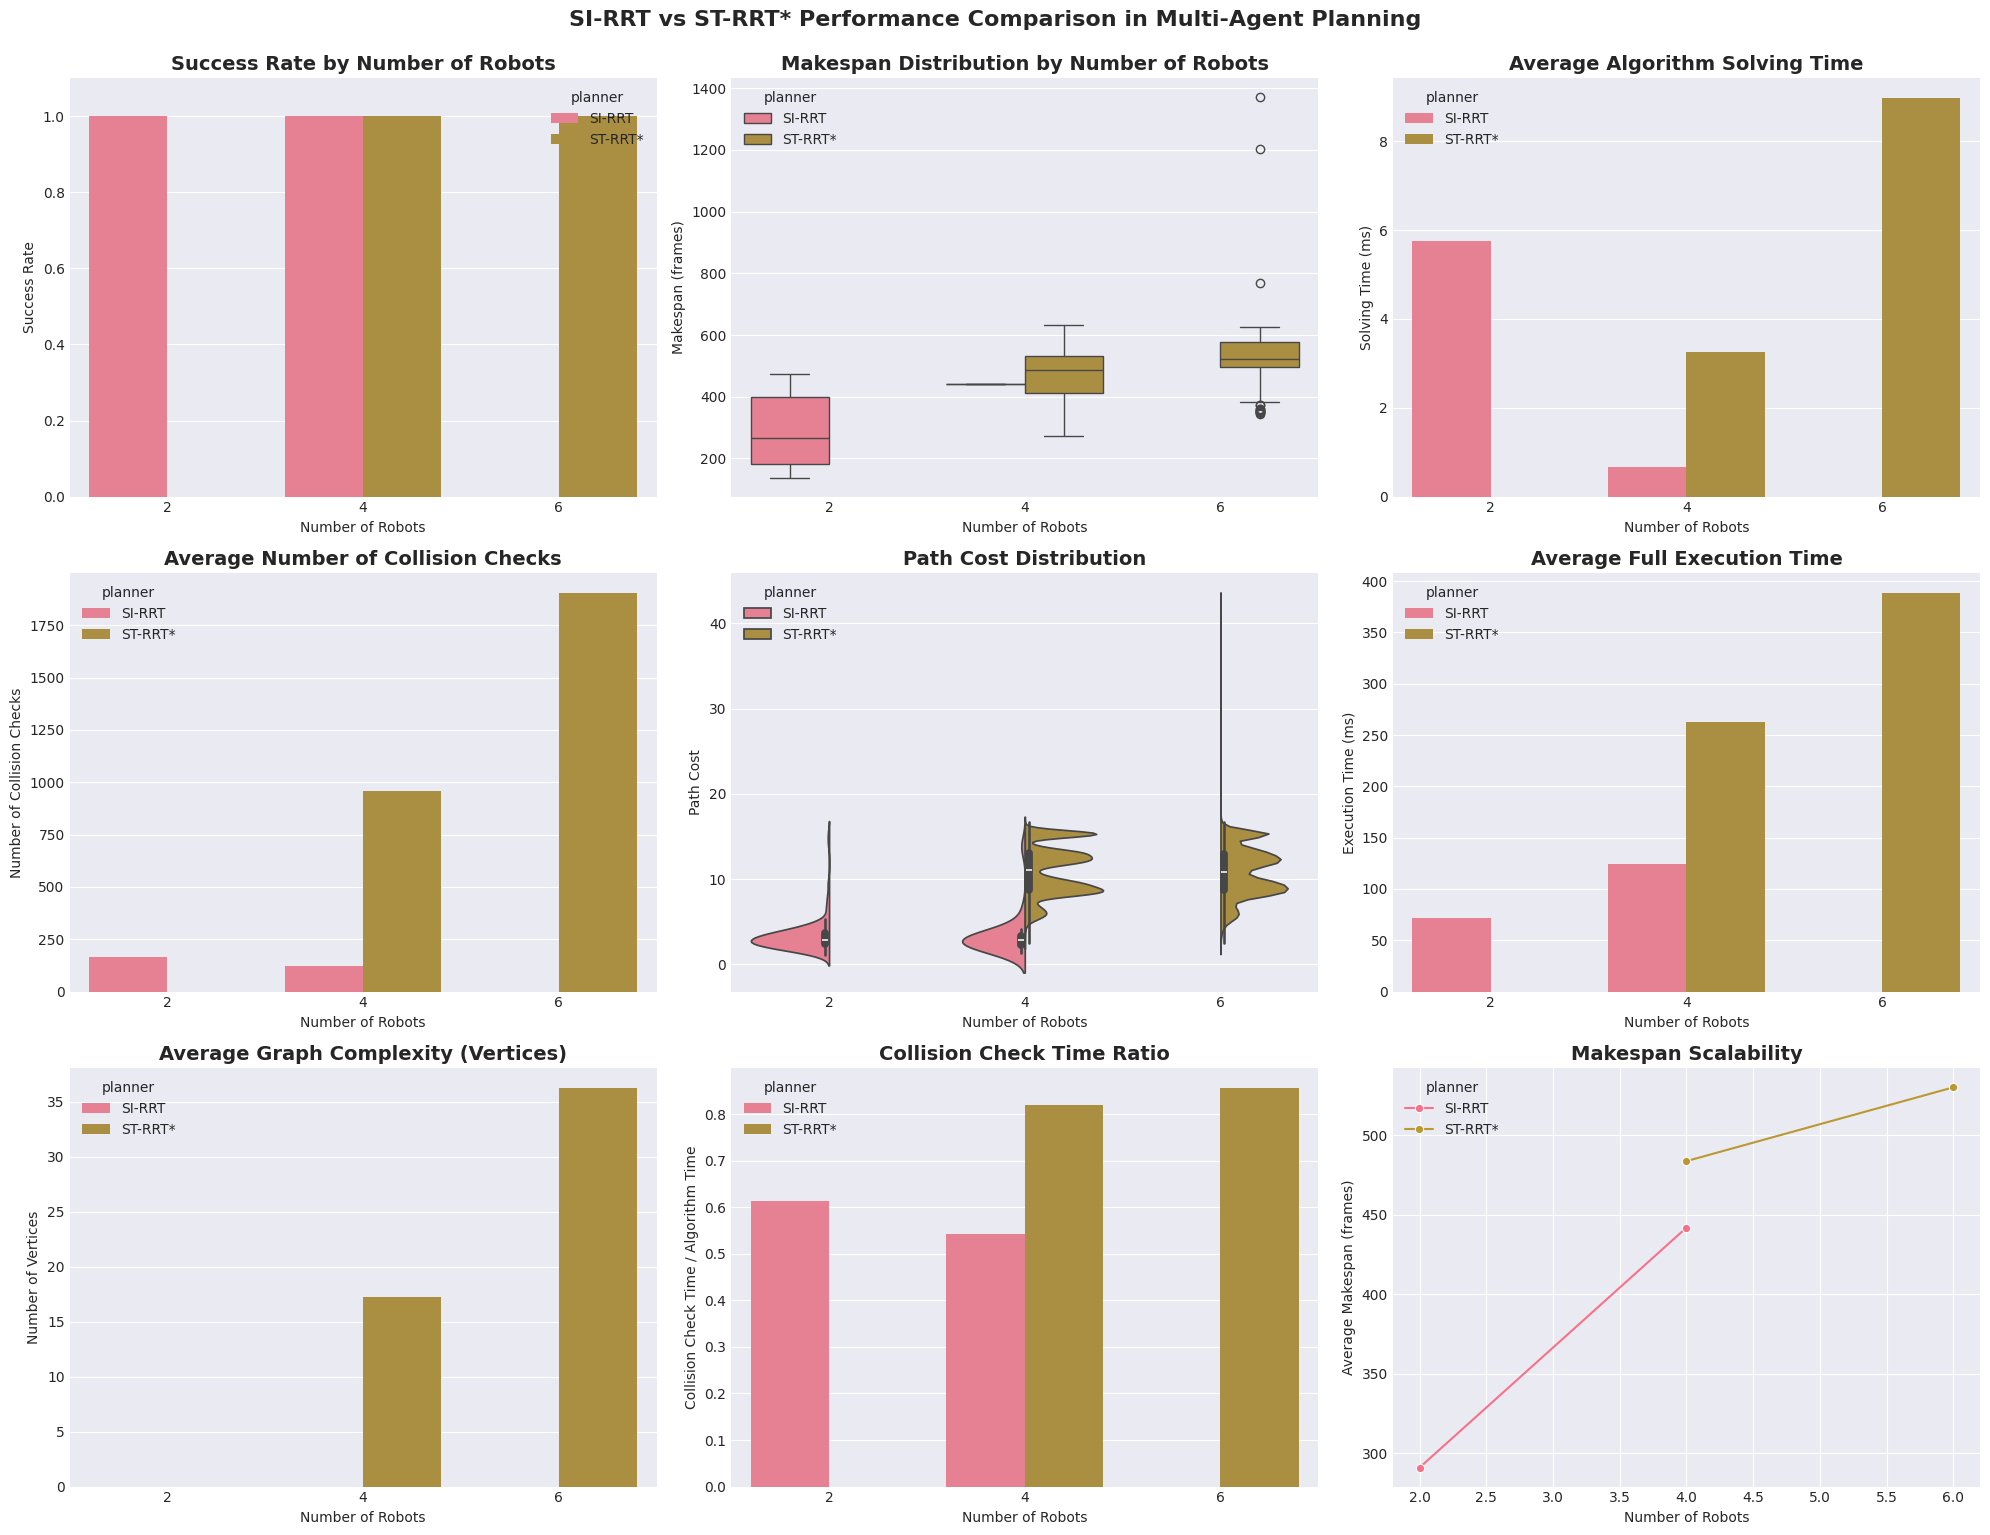

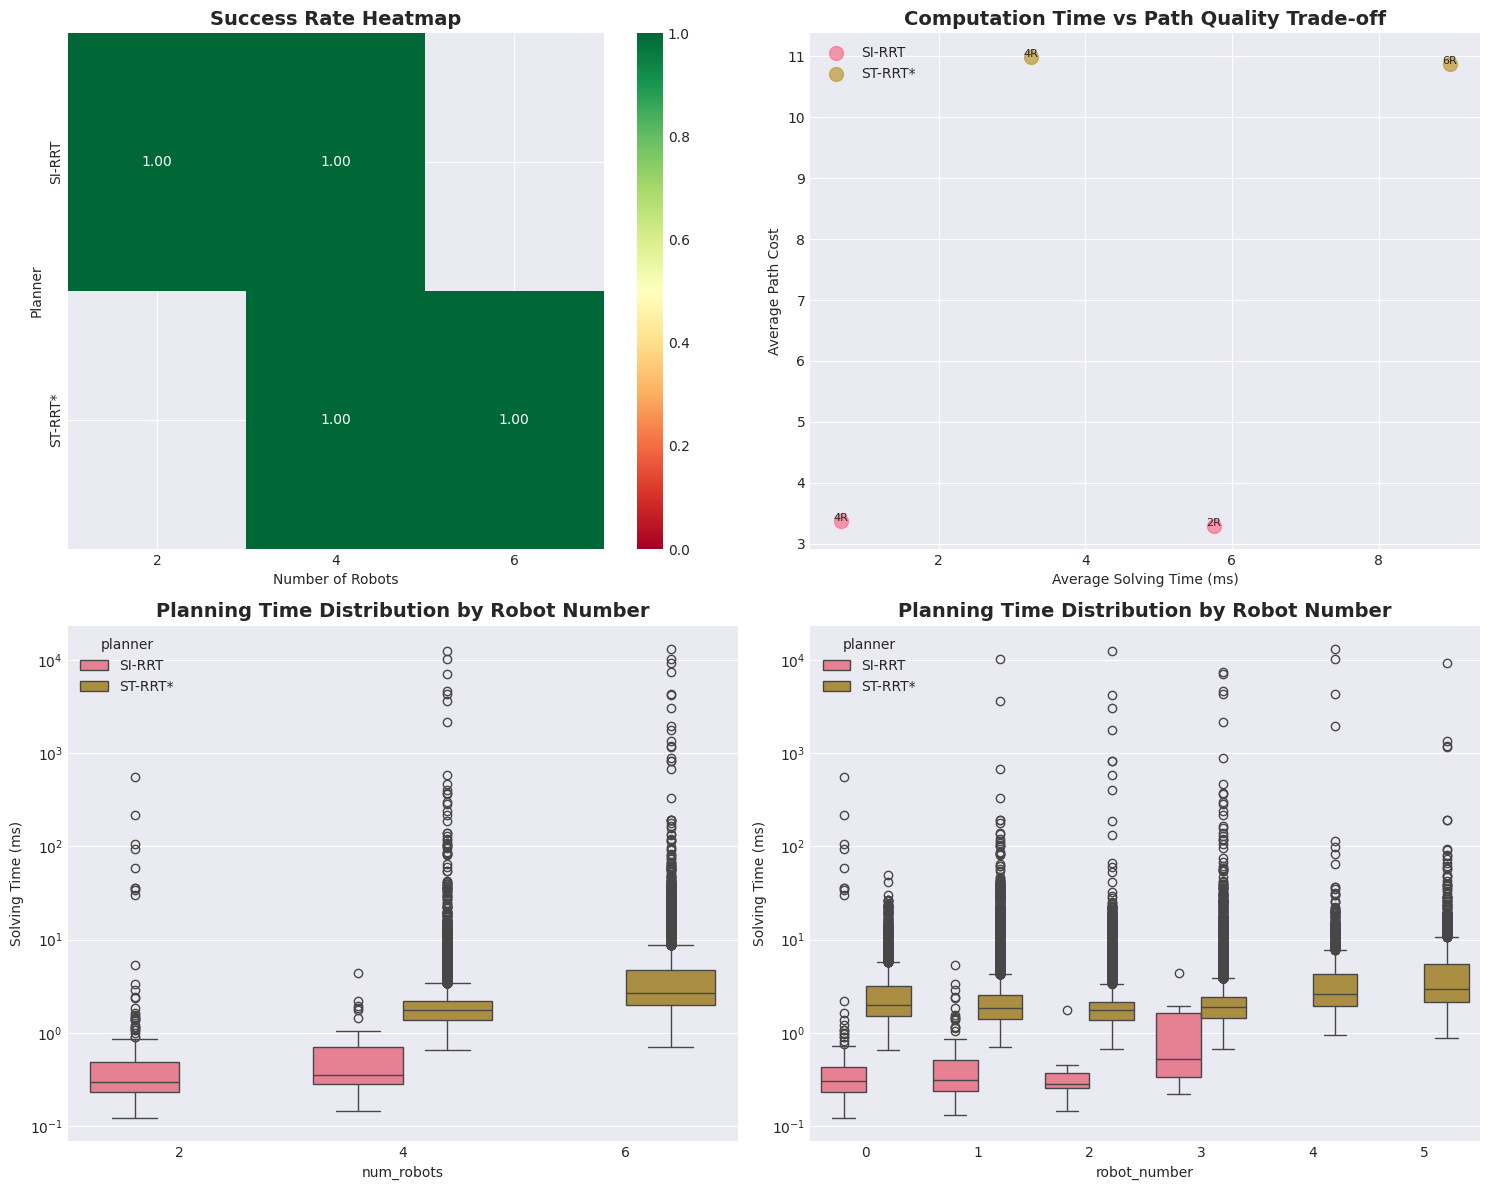

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      NaN
4              1.0      1.0
6              NaN      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  2           291.03  126.87
        4           441.91     NaN
ST-RRT* 4           483.75   89.38
        6           530.13   99.05


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2             5.75
         4             0.66
ST-RRT*  4             3.26
         6             8.97
Name: algorithm_solving_time_ns, dtype: float64


In [80]:

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('num_robots')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax4)
ax4.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax4.set_xlabel('robot_number')
ax4.set_ylabel('Solving Time (ms)')
ax4.set_yscale('log')


plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_2498/415301564.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


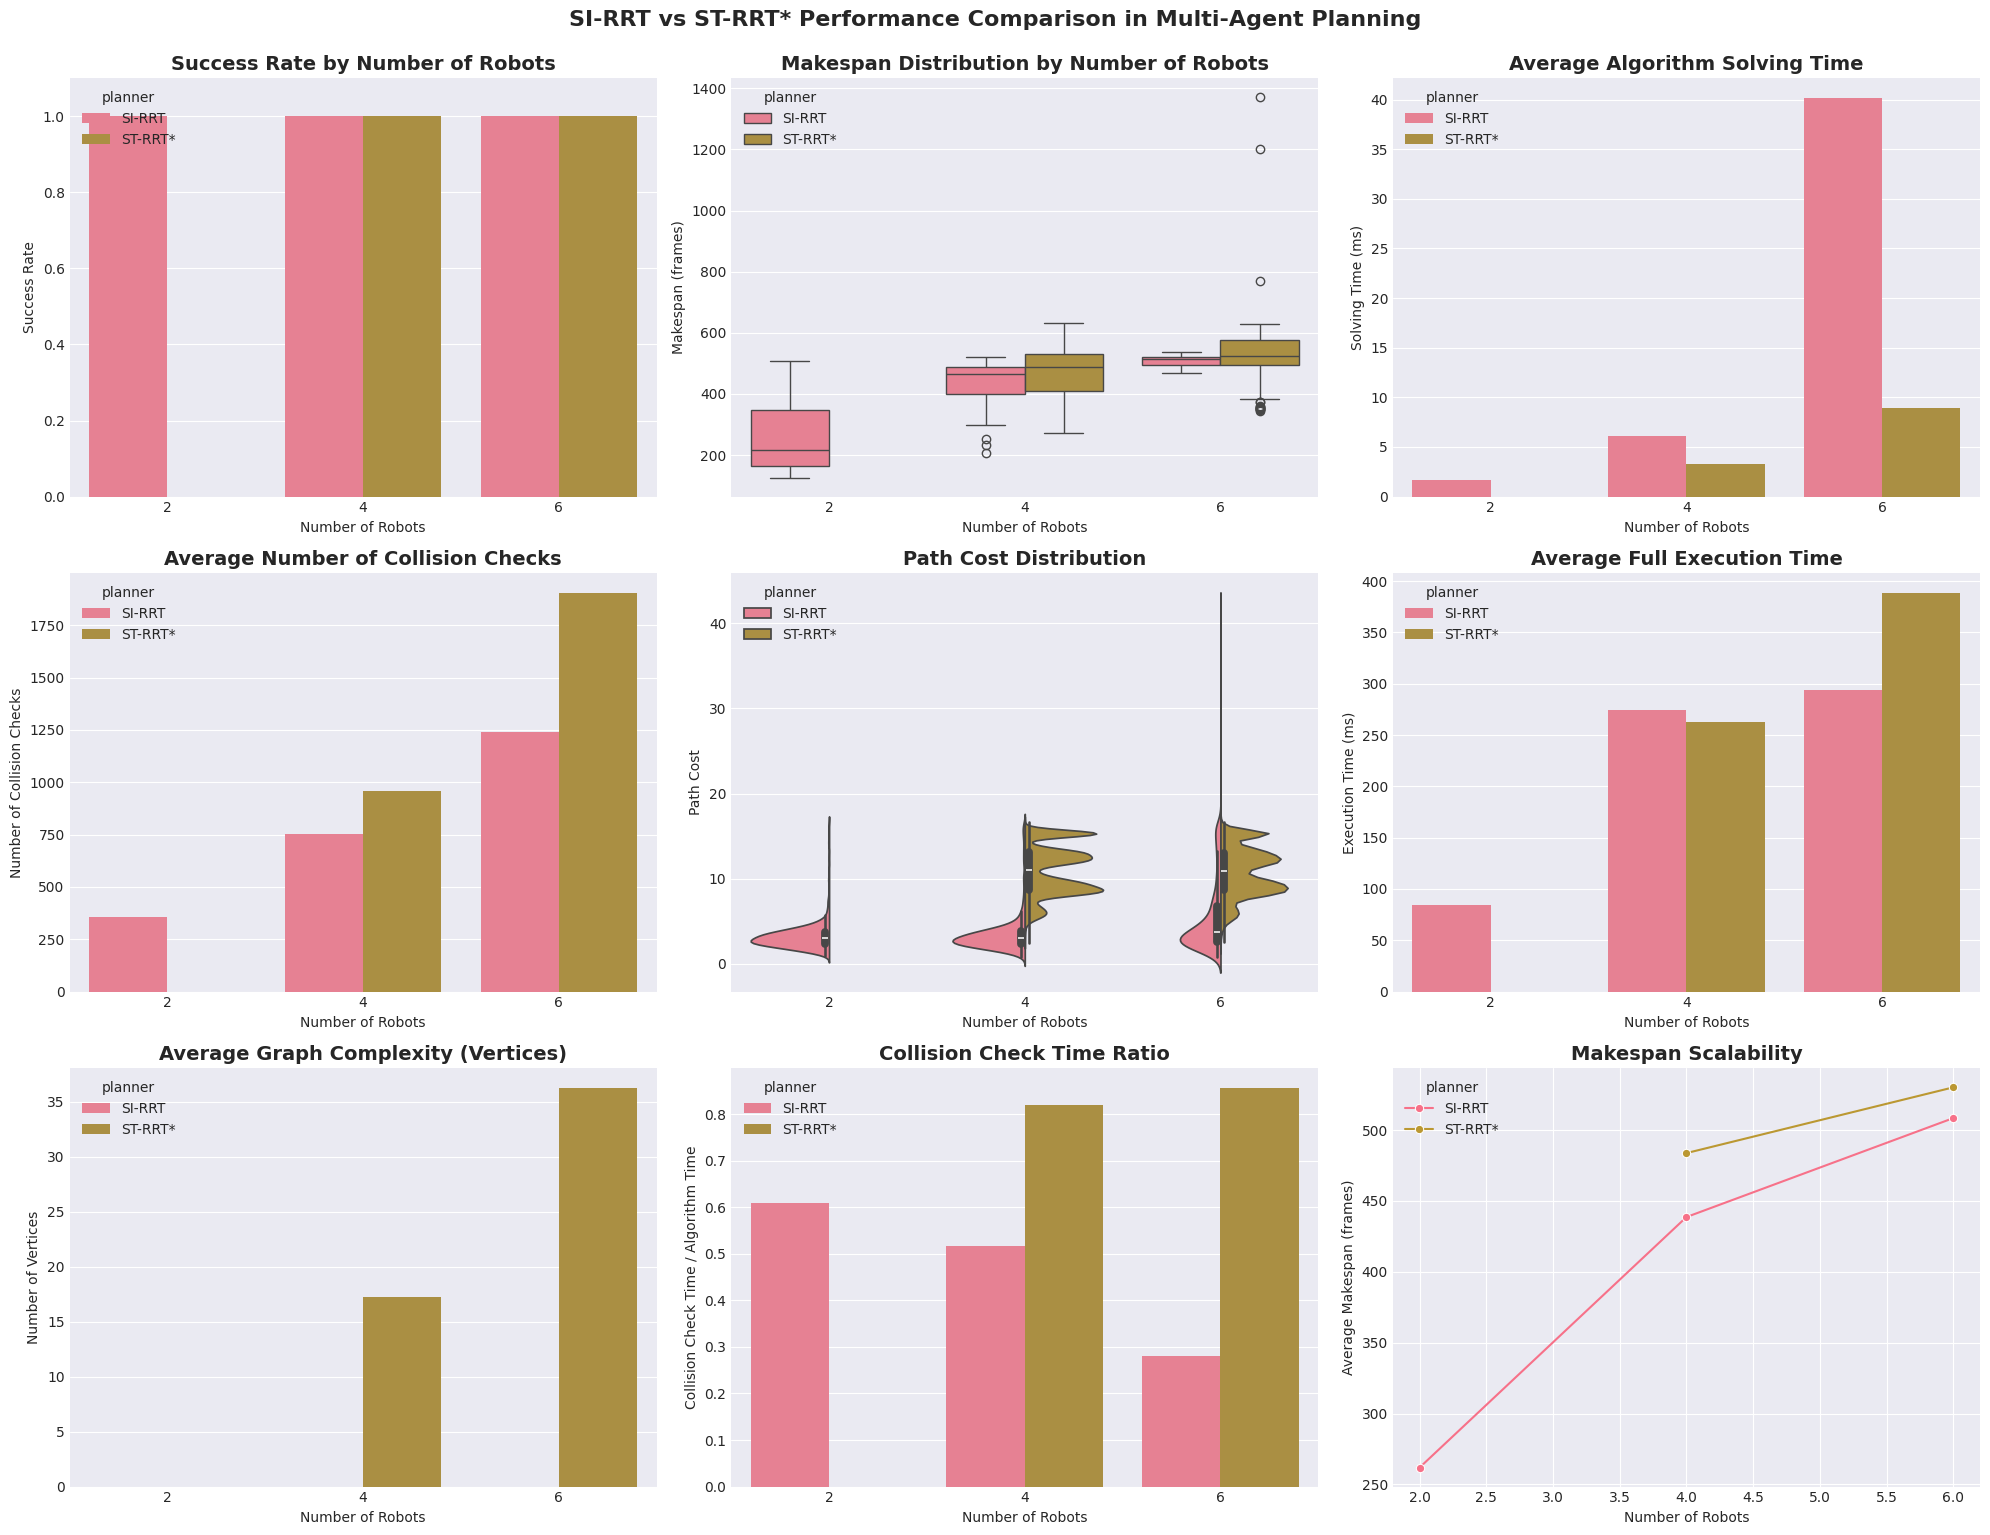

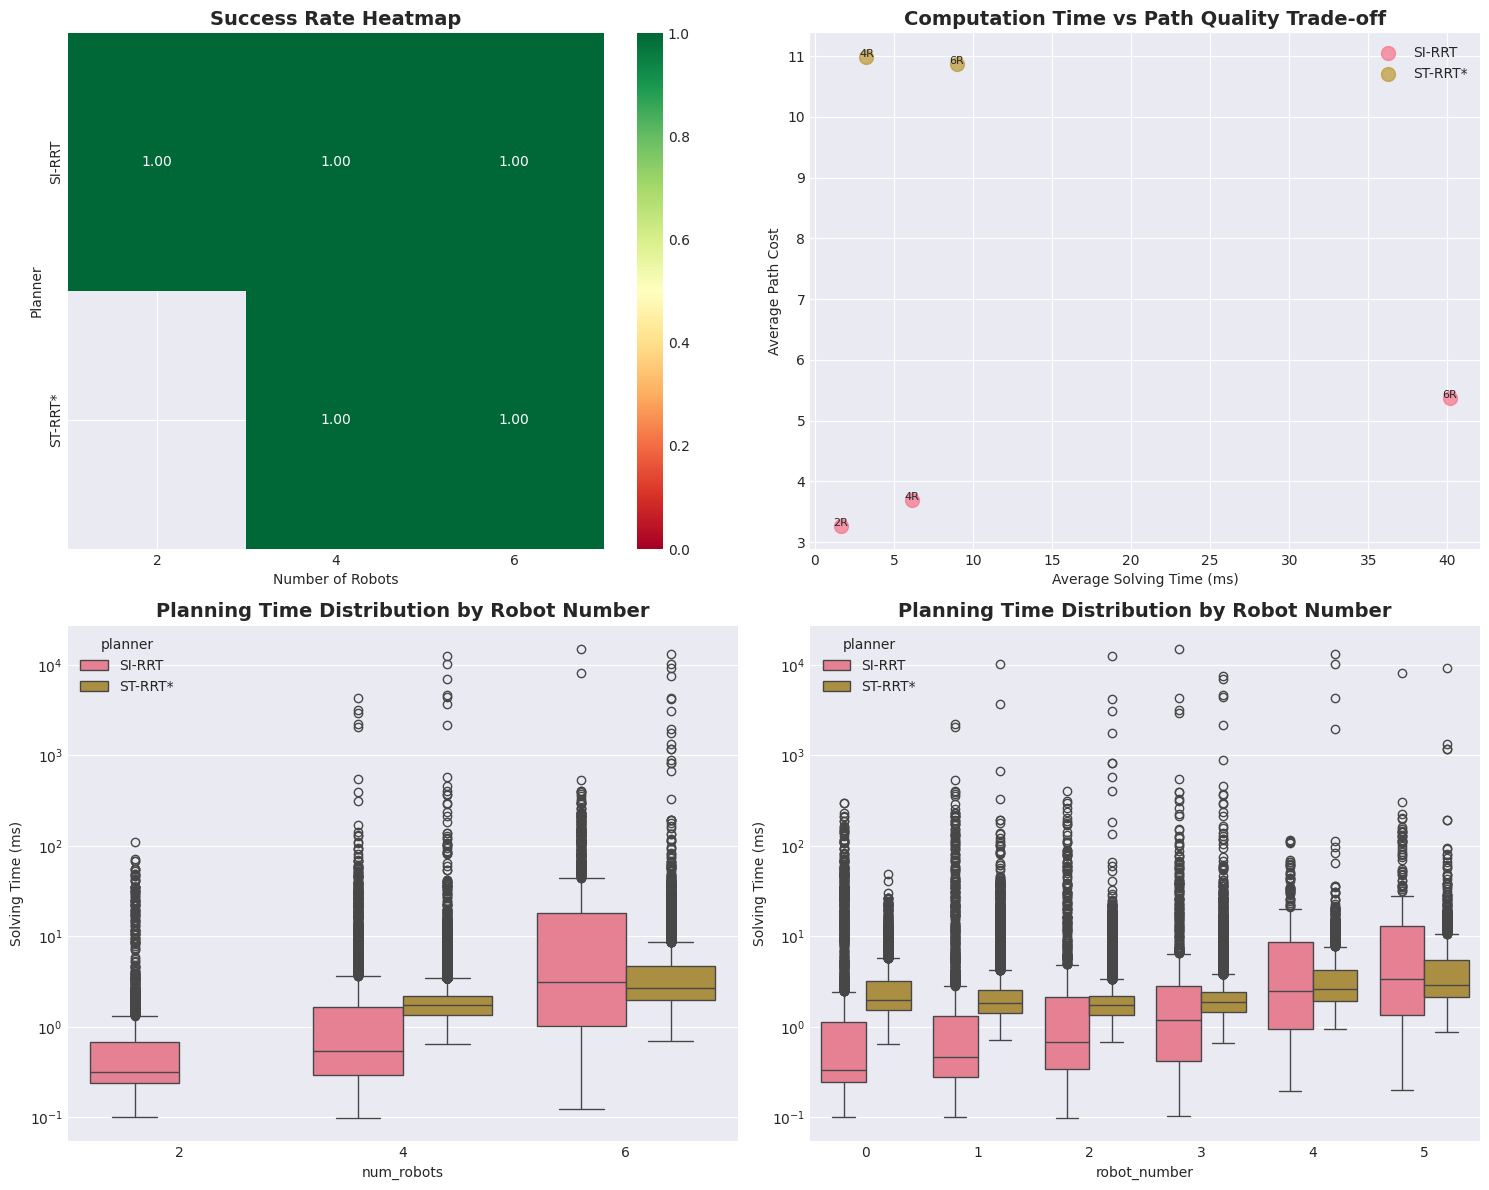

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      NaN
4              1.0      1.0
6              1.0      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  2           261.89  116.81
        4           438.62   68.00
        6           508.44   19.90
ST-RRT* 4           483.75   89.38
        6           530.13   99.05


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2              1.62
         4              6.15
         6             40.13
ST-RRT*  4              3.26
         6              8.97
Name: algorithm_solving_time_ns, dtype: float64


In [66]:

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('num_robots')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax4)
ax4.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax4.set_xlabel('robot_number')
ax4.set_ylabel('Solving Time (ms)')
ax4.set_yscale('log')


plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_670963/3386123484.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


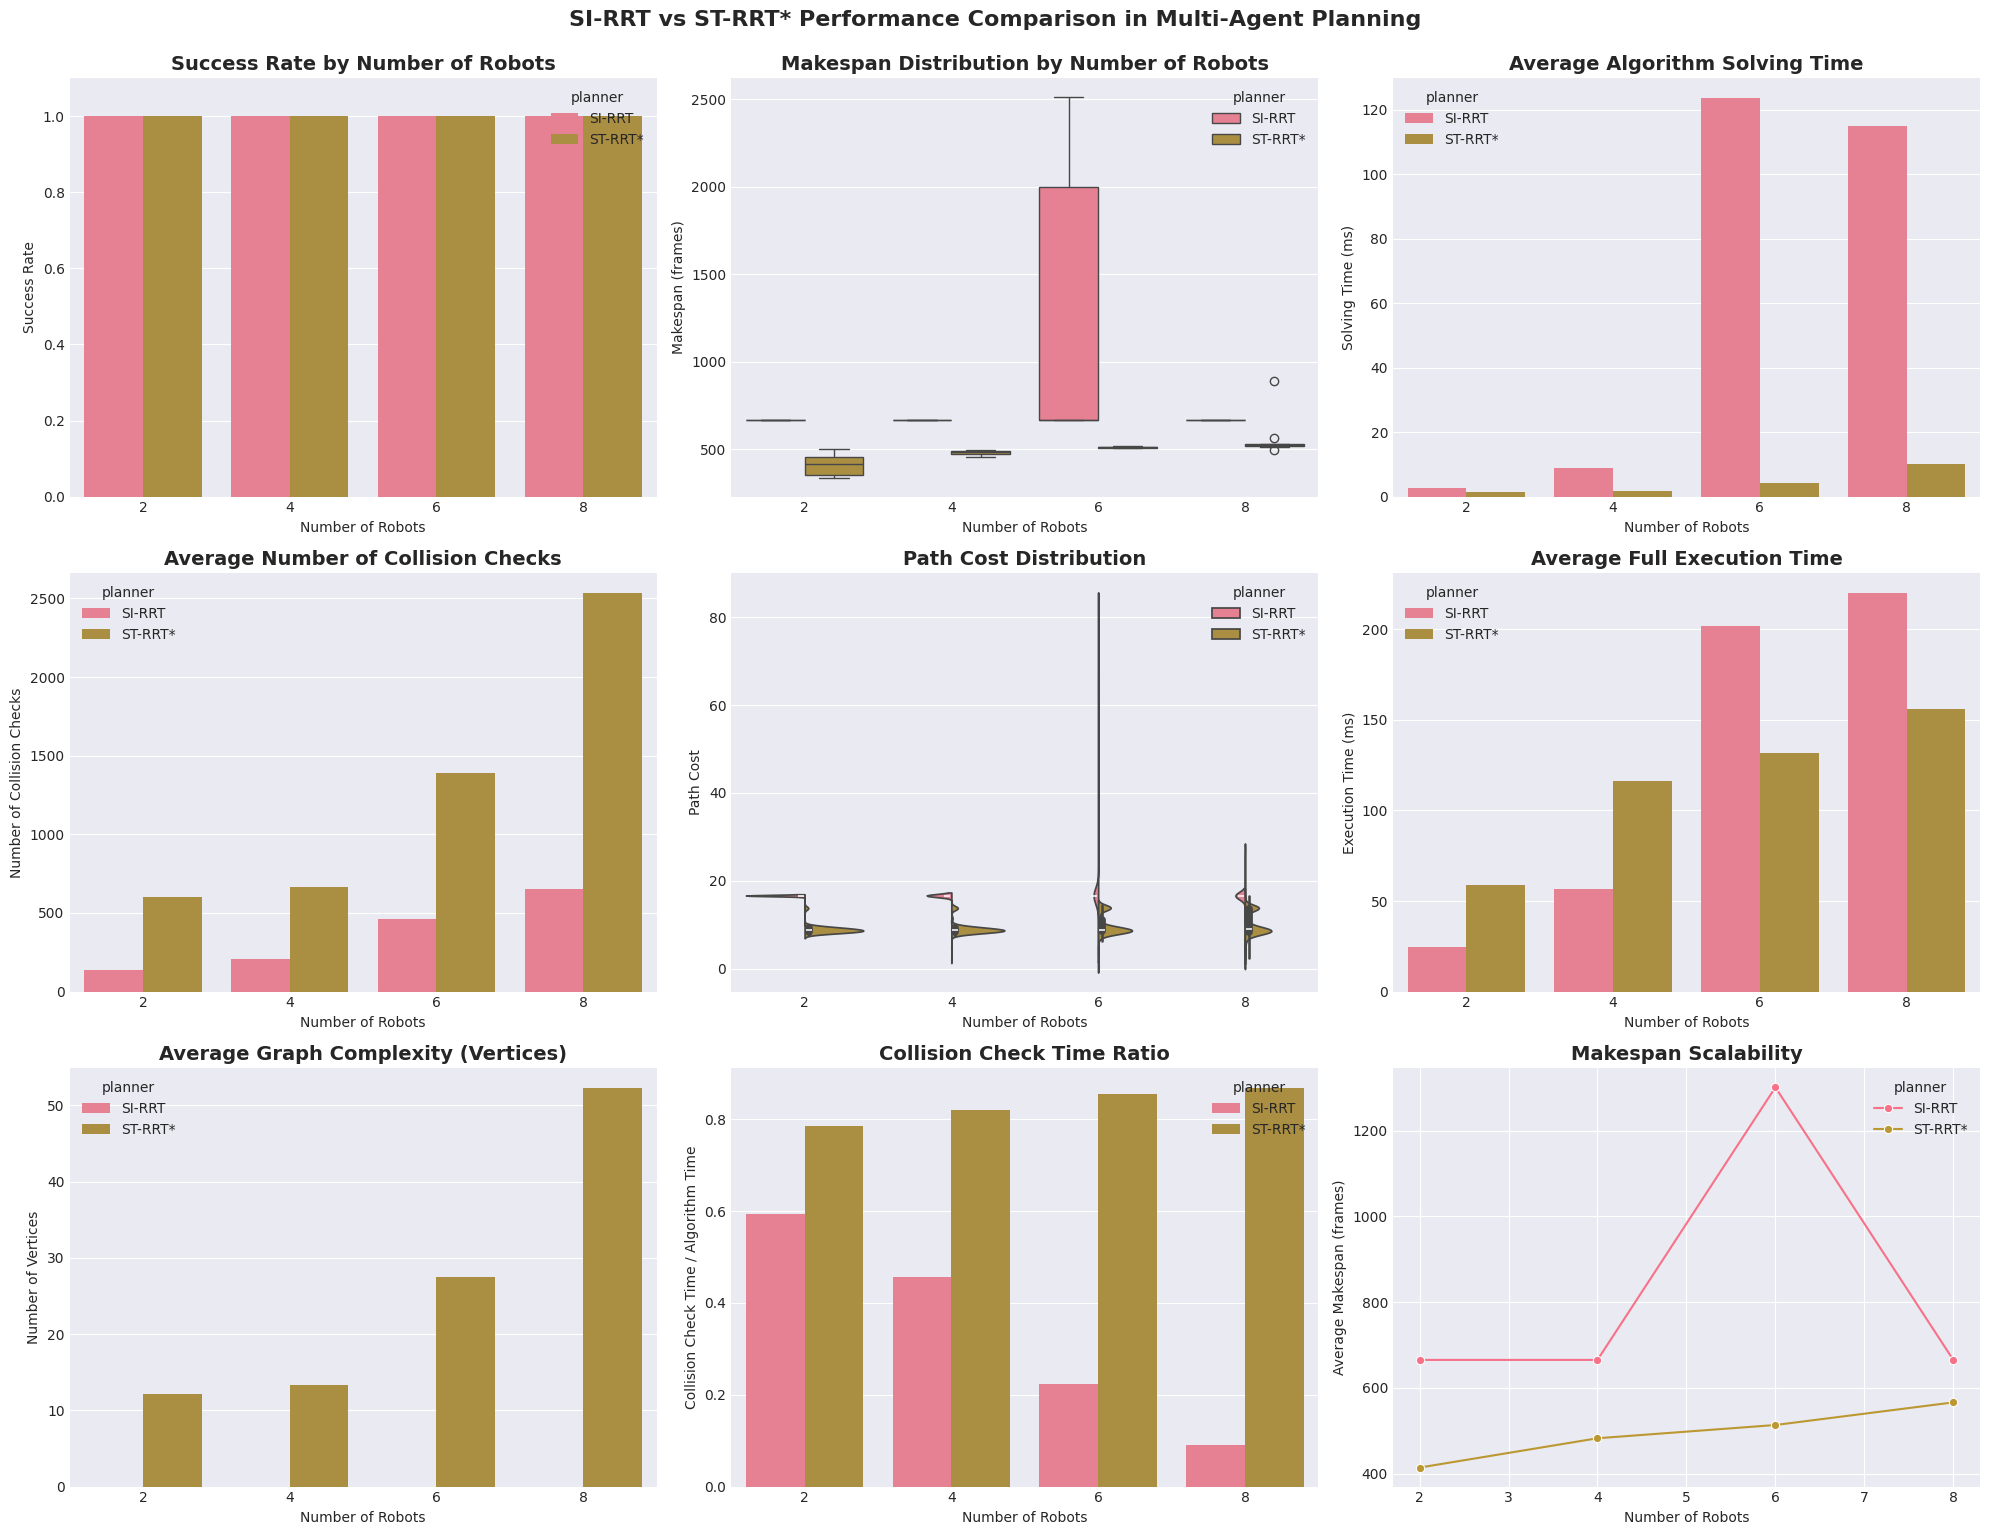

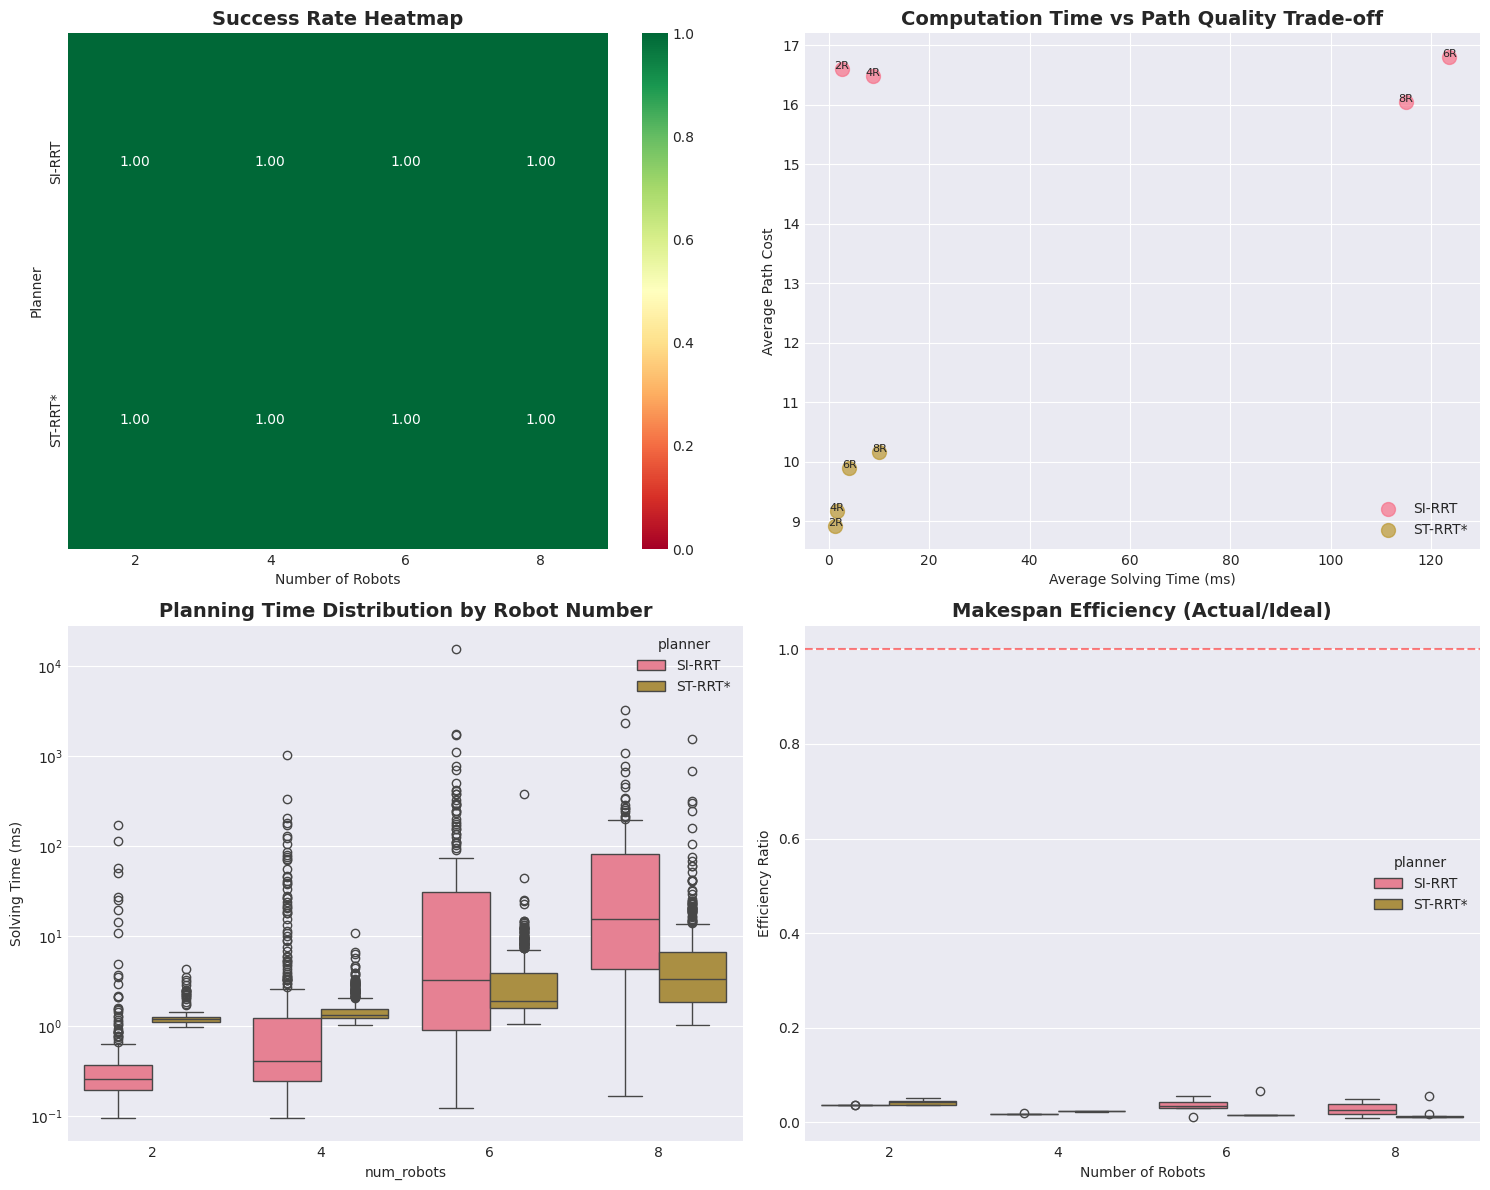

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      1.0
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                       mean     std
planner num_robots                 
SI-RRT  2            665.33    0.00
        4            665.33    0.00
        6           1301.39  889.48
        8            665.33    0.00
ST-RRT* 2            414.10   60.98
        4            482.51   14.18
        6            513.44    4.27
        8            566.18  123.08


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2               2.61
         4               8.88
         6             123.62
         8             115.01
ST-RRT*  2               1.29
         4               1.59
         6               4.13
         8              10.07
Name: algorithm_solving_

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract data from the results
def extract_data(results):
    data = []
    
    for planner_name, planner_results in [('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)]:
        for test_result in planner_results:
            test_id = test_result['test_case_id']
            num_robots = int(test_result['kolvo_robotob'])
            success = test_result['success']
            seed = test_result['seed']
            
            # Extract planning instances data
            for instance in test_result['planning_instances']:
                robot_num = instance['robot_number']
                start_time = instance['start_time']
                
                # Extract metrics from data
                instance_data = instance['data']
                
                data.append({
                    'planner': planner_name,
                    'test_id': test_id,
                    'num_robots': num_robots,
                    'success': success,
                    'seed': seed,
                    'robot_number': robot_num,
                    'start_time': start_time,
                    'has_result': instance_data['final_planner_data']['has_result'],
                    'path_cost': instance_data['final_planner_data'].get('path_cost', np.nan),
                    'algorithm_solving_time_ns': instance_data['algorithm_solving_time_ns'],
                    'collision_check_time_ns': instance_data['collision_check_time_ns'],
                    'number_of_collision_checks': instance_data['number_of_collision_checks'],
                    'full_execution_time_ns': instance_data['full_execution_time_ns'],
                    'number_of_vertices': instance_data['final_planner_data'].get('number_of_vertices', 0),
                    'number_of_edges': instance_data['final_planner_data'].get('number_of_edges', 0)
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = extract_data([('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)])

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('num_robots')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

sns.boxplot(data=efficiency_df, x='num_robots', y='efficiency', hue='planner', ax=ax4)
ax4.set_title('Makespan Efficiency (Actual/Ideal)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Efficiency Ratio')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Ideal')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_2718/1611386964.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


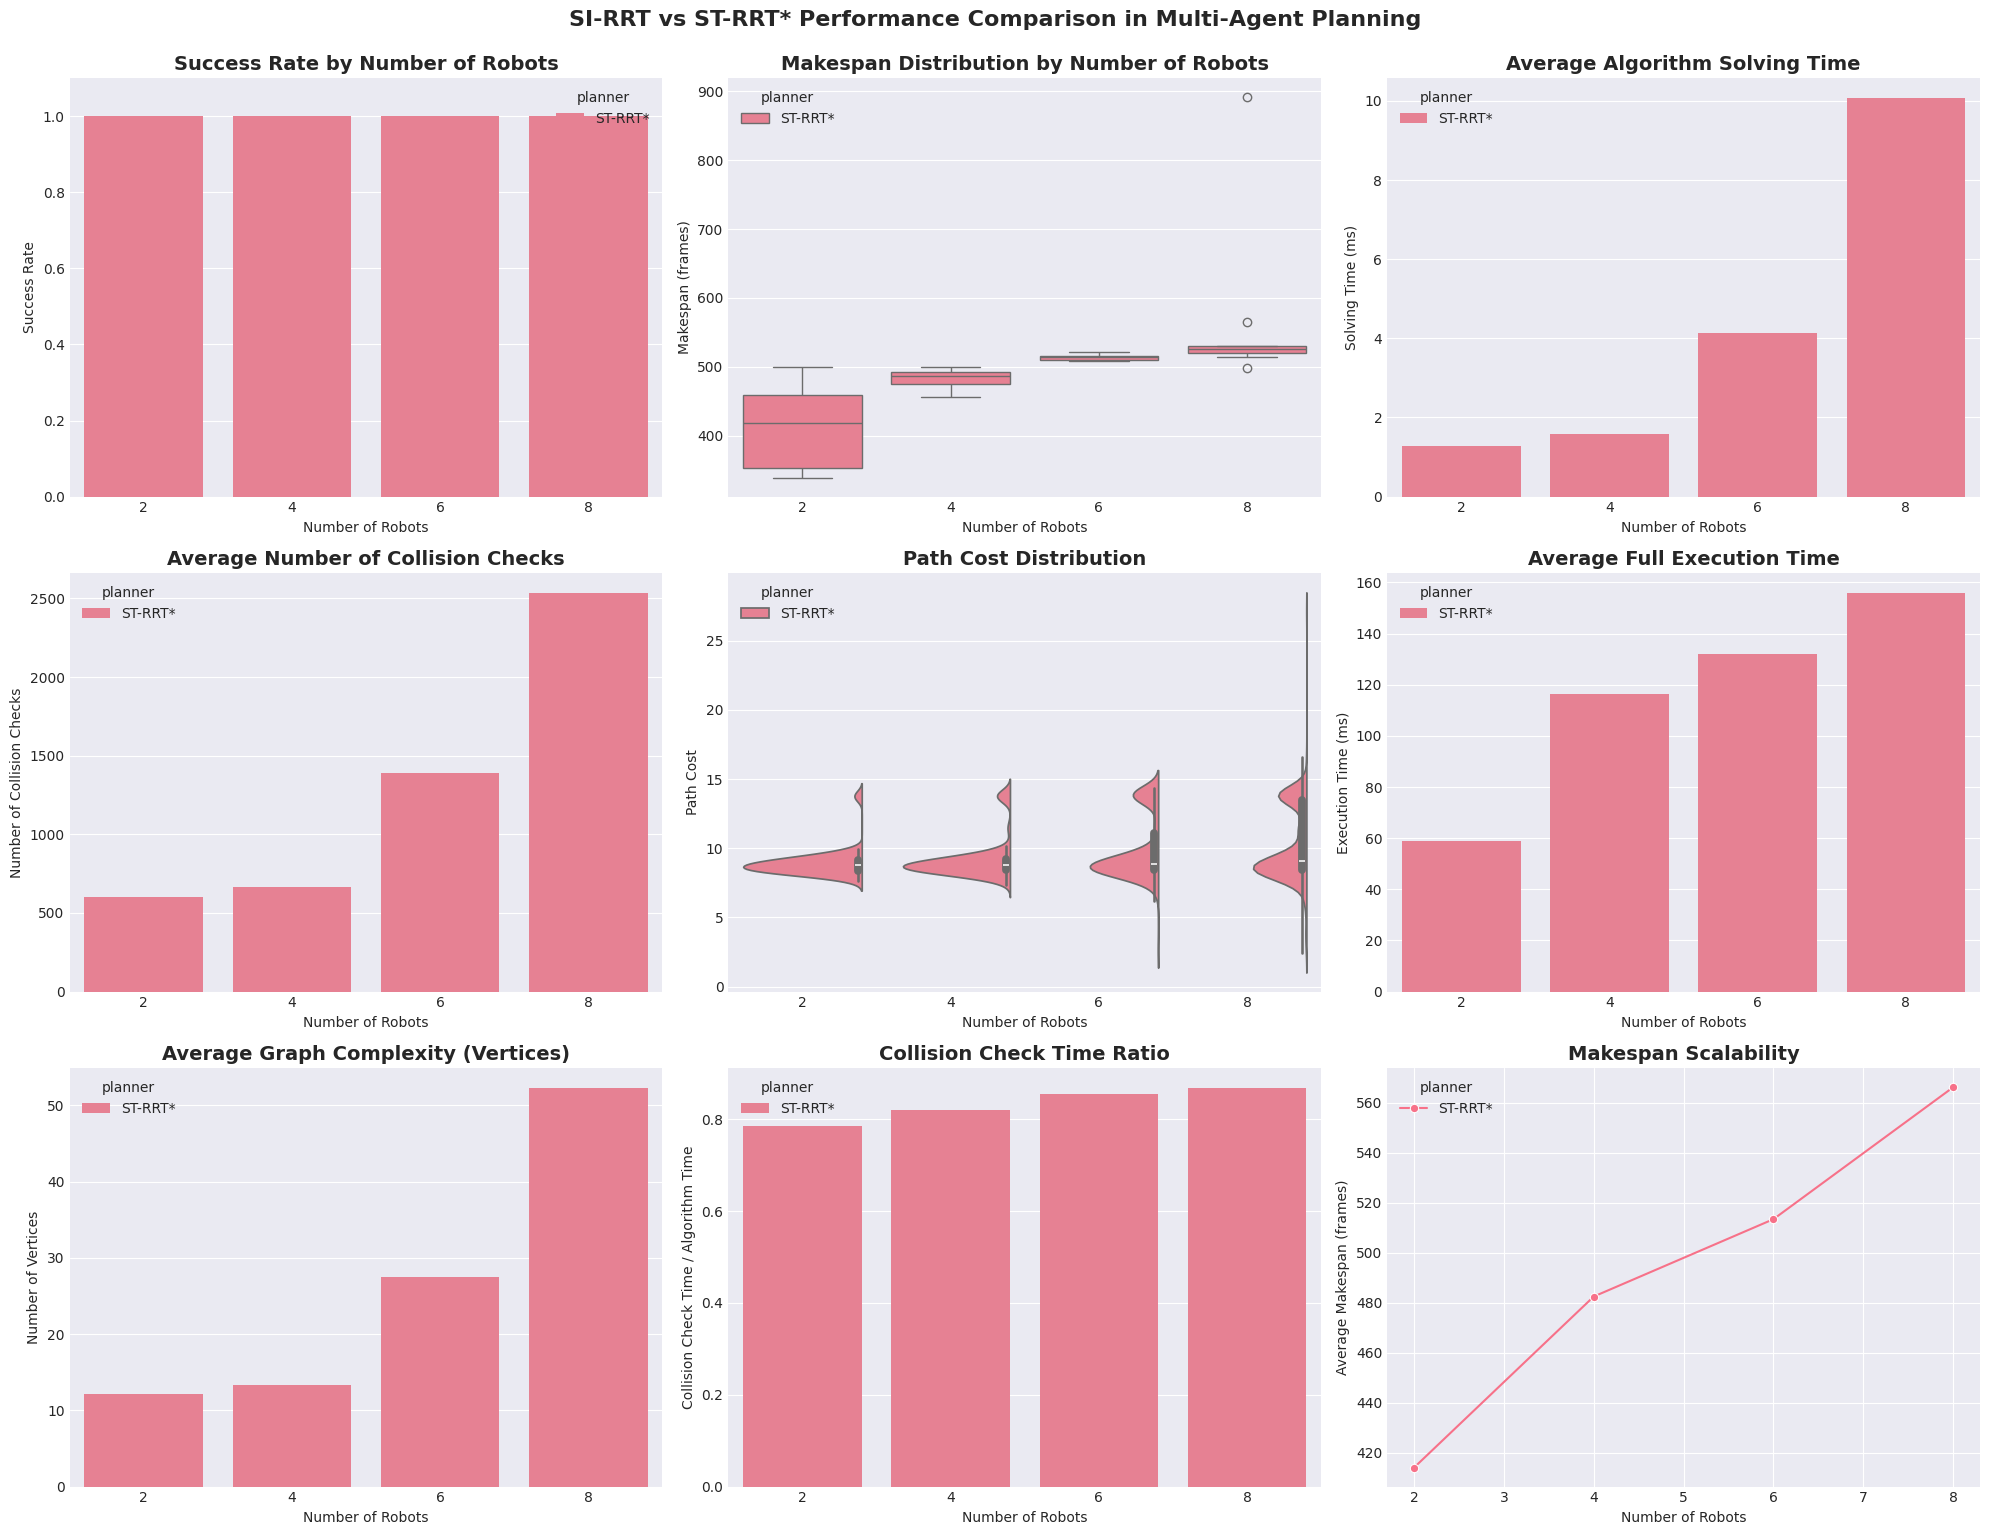

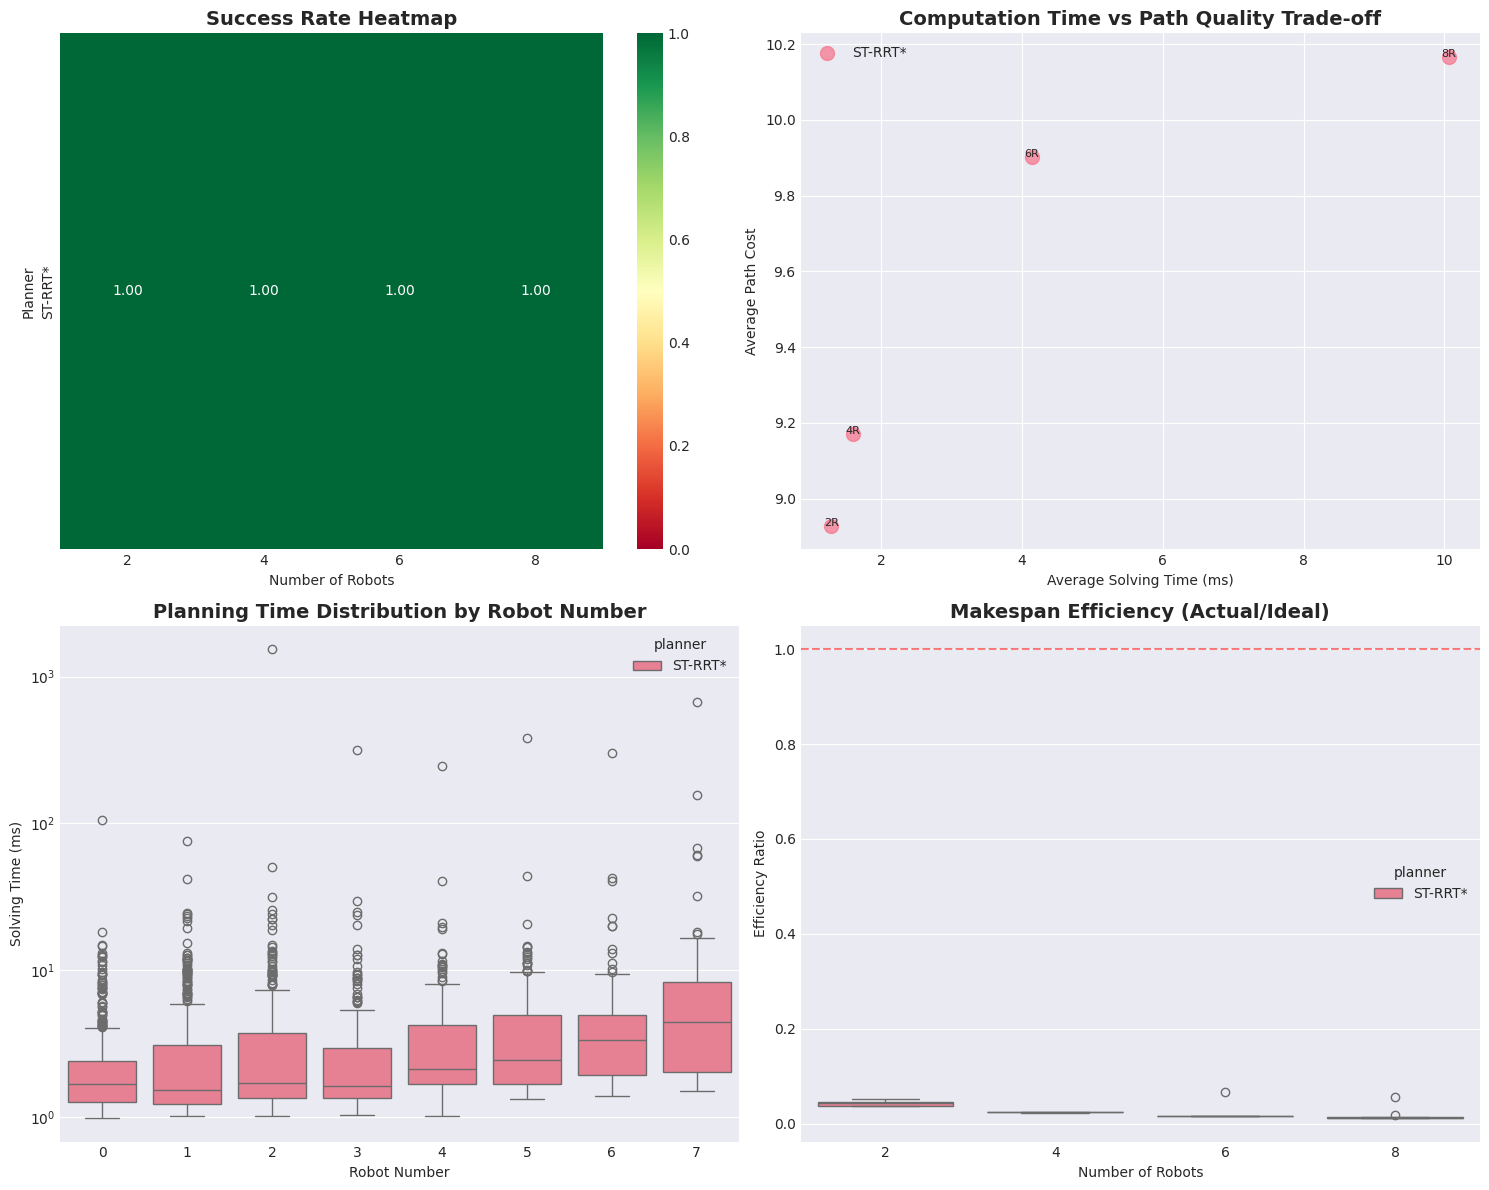

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     ST-RRT*
num_robots         
2               1.0
4               1.0
6               1.0
8               1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
ST-RRT* 2           414.10   60.98
        4           482.51   14.18
        6           513.44    4.27
        8           566.18  123.08


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
ST-RRT*  2              1.29
         4              1.59
         6              4.13
         8             10.07
Name: algorithm_solving_time_ns, dtype: float64


In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract data from the results
def extract_data(results):
    data = []
    
    for planner_name, planner_results in [('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)]:
        for test_result in planner_results:
            test_id = test_result['test_case_id']
            num_robots = int(test_result['kolvo_robotob'])
            success = test_result['success']
            seed = test_result['seed']
            
            # Extract planning instances data
            for instance in test_result['planning_instances']:
                robot_num = instance['robot_number']
                start_time = instance['start_time']
                
                # Extract metrics from data
                instance_data = instance['data']
                
                data.append({
                    'planner': planner_name,
                    'test_id': test_id,
                    'num_robots': num_robots,
                    'success': success,
                    'seed': seed,
                    'robot_number': robot_num,
                    'start_time': start_time,
                    'has_result': instance_data['final_planner_data']['has_result'],
                    'path_cost': instance_data['final_planner_data'].get('path_cost', np.nan),
                    'algorithm_solving_time_ns': instance_data['algorithm_solving_time_ns'],
                    'collision_check_time_ns': instance_data['collision_check_time_ns'],
                    'number_of_collision_checks': instance_data['number_of_collision_checks'],
                    'full_execution_time_ns': instance_data['full_execution_time_ns'],
                    'number_of_vertices': instance_data['final_planner_data'].get('number_of_vertices', 0),
                    'number_of_edges': instance_data['final_planner_data'].get('number_of_edges', 0)
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = extract_data([('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)])

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('Robot Number')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

sns.boxplot(data=efficiency_df, x='num_robots', y='efficiency', hue='planner', ax=ax4)
ax4.set_title('Makespan Efficiency (Actual/Ideal)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Efficiency Ratio')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Ideal')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_670963/1611386964.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


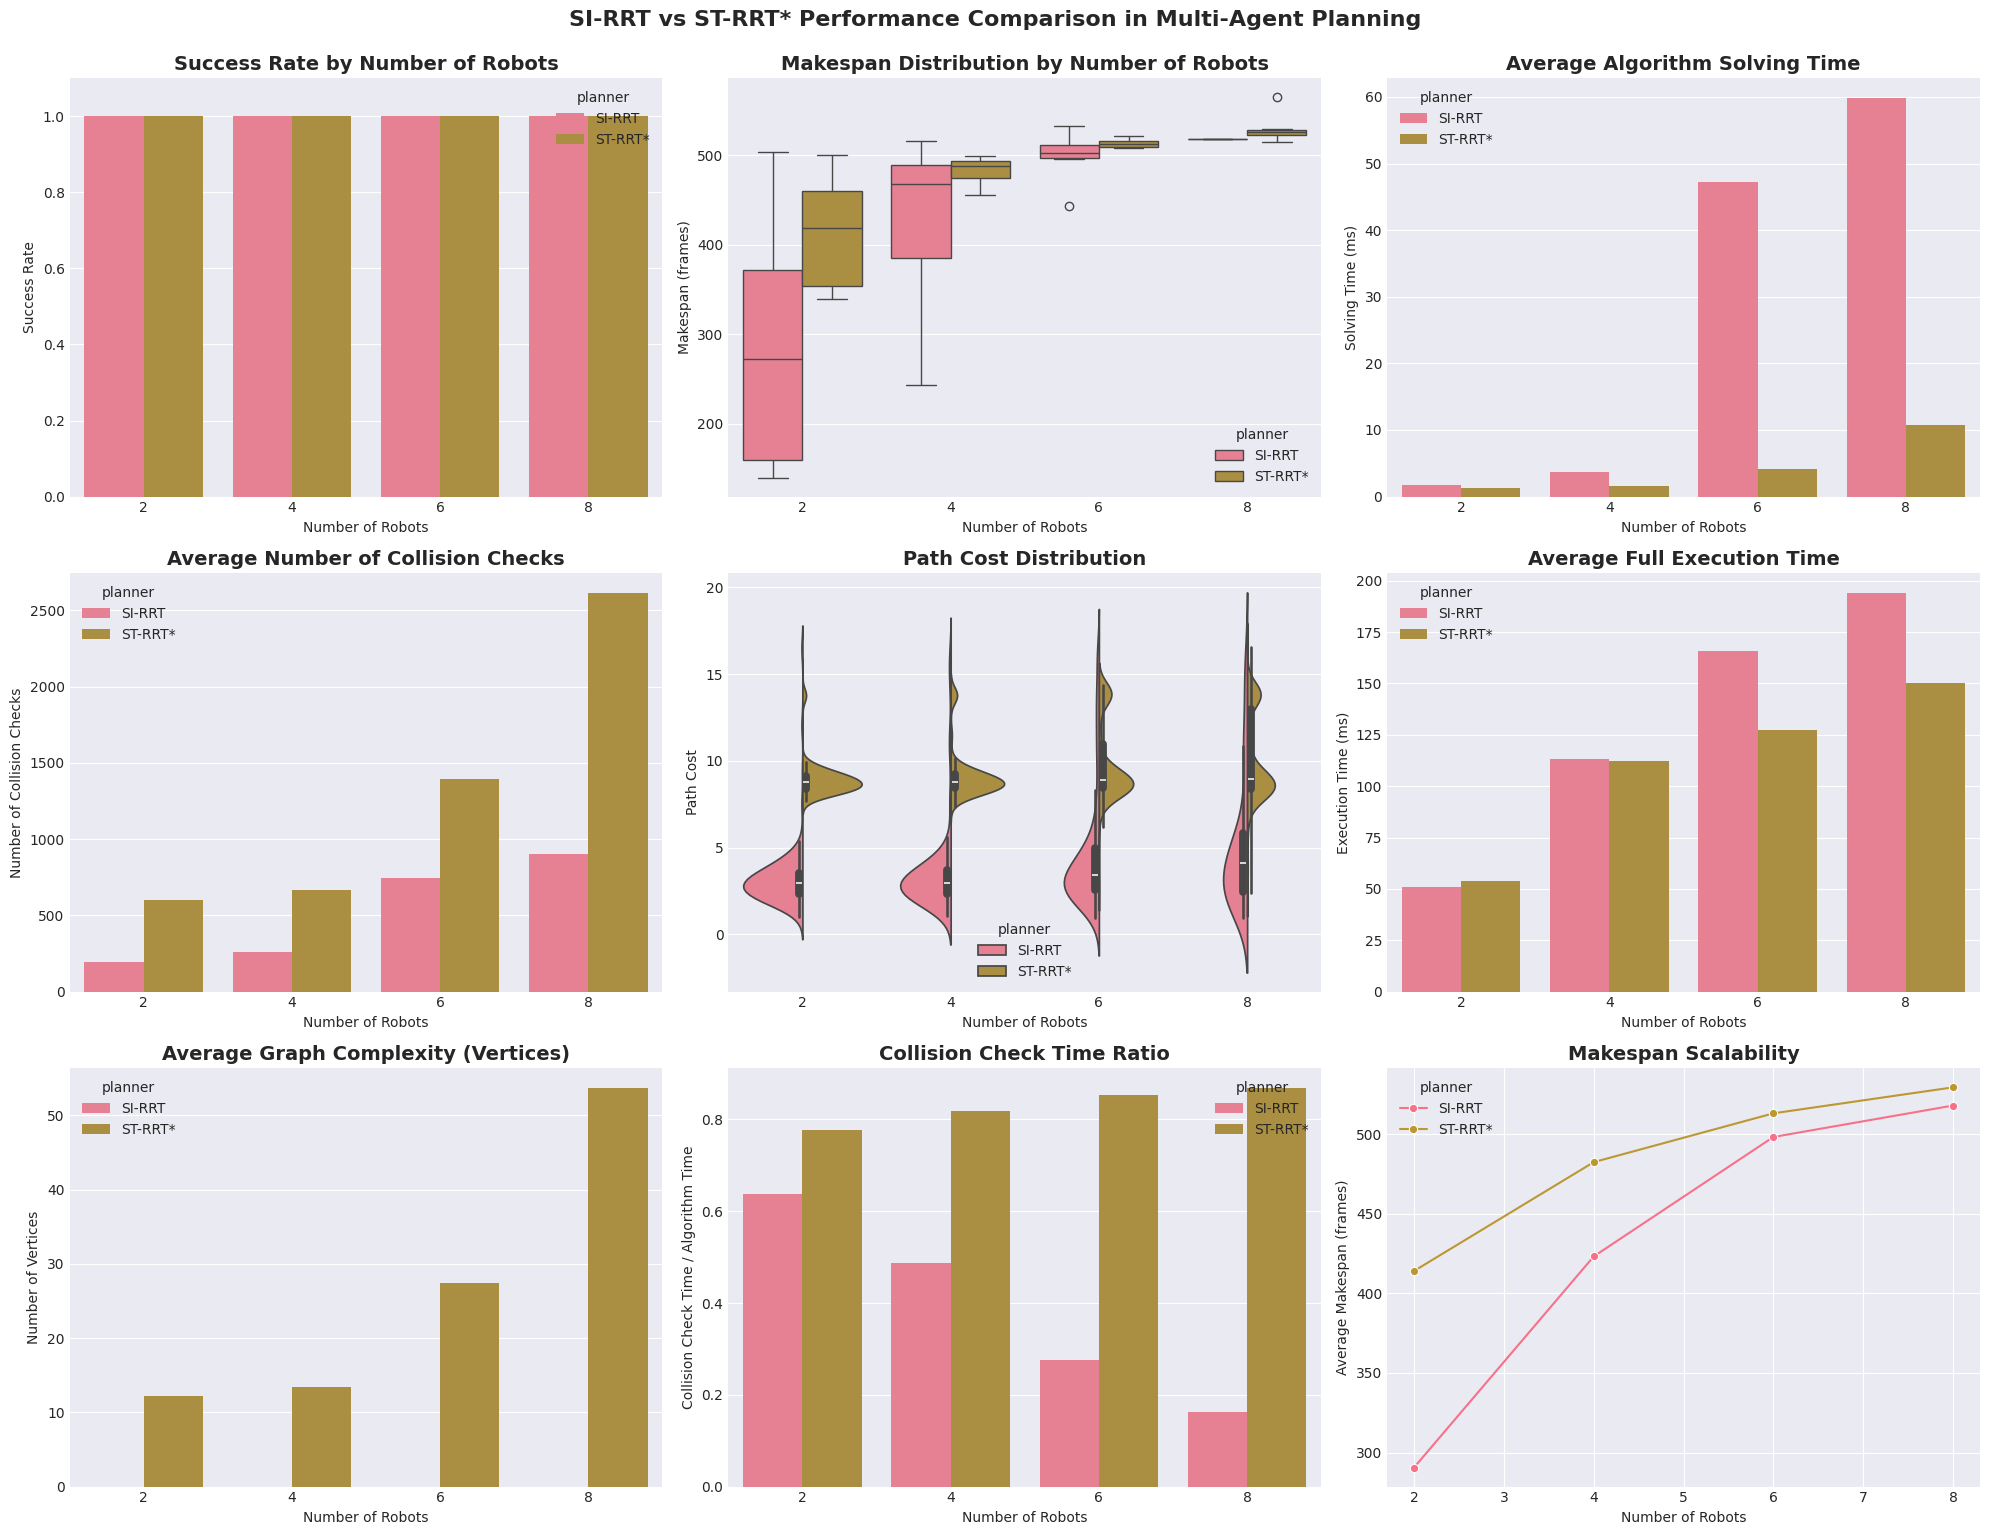

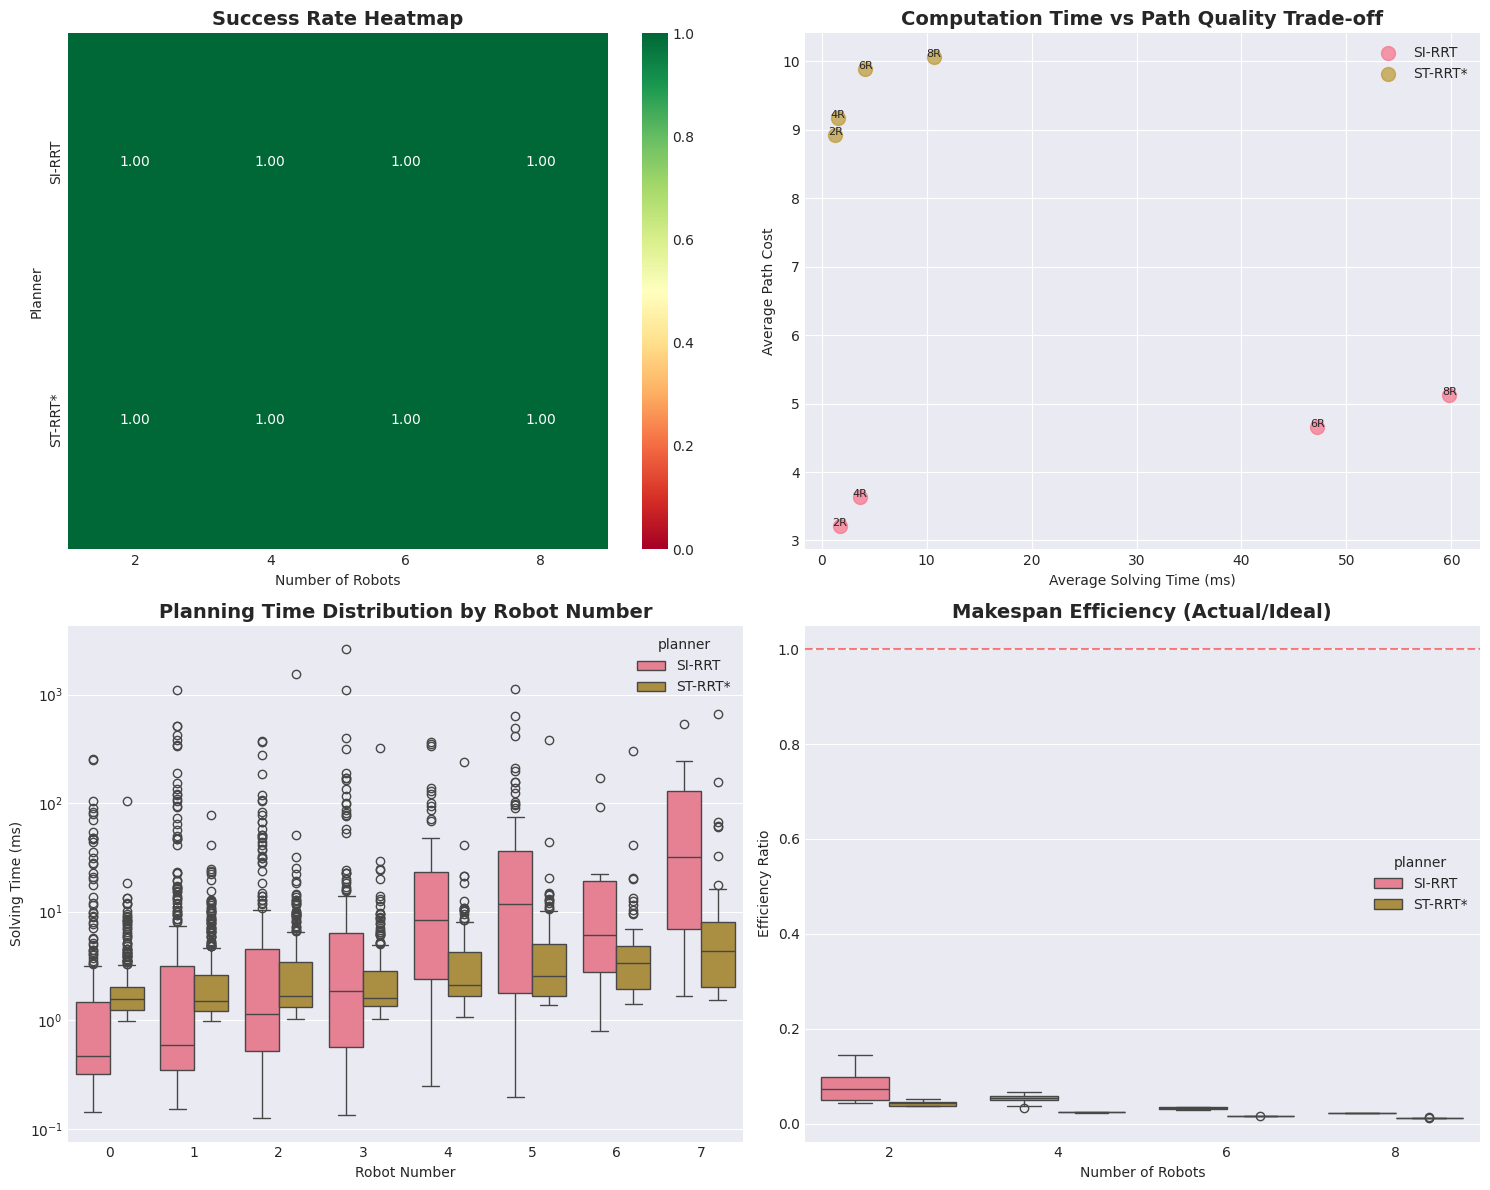

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      1.0
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  2           290.54  140.74
        4           423.23   99.41
        6           498.33   29.77
        8           518.09     NaN
ST-RRT* 2           414.10   60.98
        4           482.51   14.18
        6           513.20    4.50
        8           529.53   16.23


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2              1.72
         4              3.66
         6             47.24
         8             59.80
ST-RRT*  2              1.29
         4              1.58
         6              4.14
         8             10.68
Name: algorithm_solving_time_ns, dtype: fl

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract data from the results
def extract_data(results):
    data = []
    
    for planner_name, planner_results in [('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)]:
        for test_result in planner_results:
            test_id = test_result['test_case_id']
            num_robots = int(test_result['kolvo_robotob'])
            success = test_result['success']
            seed = test_result['seed']
            
            # Extract planning instances data
            for instance in test_result['planning_instances']:
                robot_num = instance['robot_number']
                start_time = instance['start_time']
                
                # Extract metrics from data
                instance_data = instance['data']
                
                data.append({
                    'planner': planner_name,
                    'test_id': test_id,
                    'num_robots': num_robots,
                    'success': success,
                    'seed': seed,
                    'robot_number': robot_num,
                    'start_time': start_time,
                    'has_result': instance_data['final_planner_data']['has_result'],
                    'path_cost': instance_data['final_planner_data'].get('path_cost', np.nan),
                    'algorithm_solving_time_ns': instance_data['algorithm_solving_time_ns'],
                    'collision_check_time_ns': instance_data['collision_check_time_ns'],
                    'number_of_collision_checks': instance_data['number_of_collision_checks'],
                    'full_execution_time_ns': instance_data['full_execution_time_ns'],
                    'number_of_vertices': instance_data['final_planner_data'].get('number_of_vertices', 0),
                    'number_of_edges': instance_data['final_planner_data'].get('number_of_edges', 0)
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = extract_data([('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)])

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('Robot Number')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

sns.boxplot(data=efficiency_df, x='num_robots', y='efficiency', hue='planner', ax=ax4)
ax4.set_title('Makespan Efficiency (Actual/Ideal)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Efficiency Ratio')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Ideal')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_670963/1611386964.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


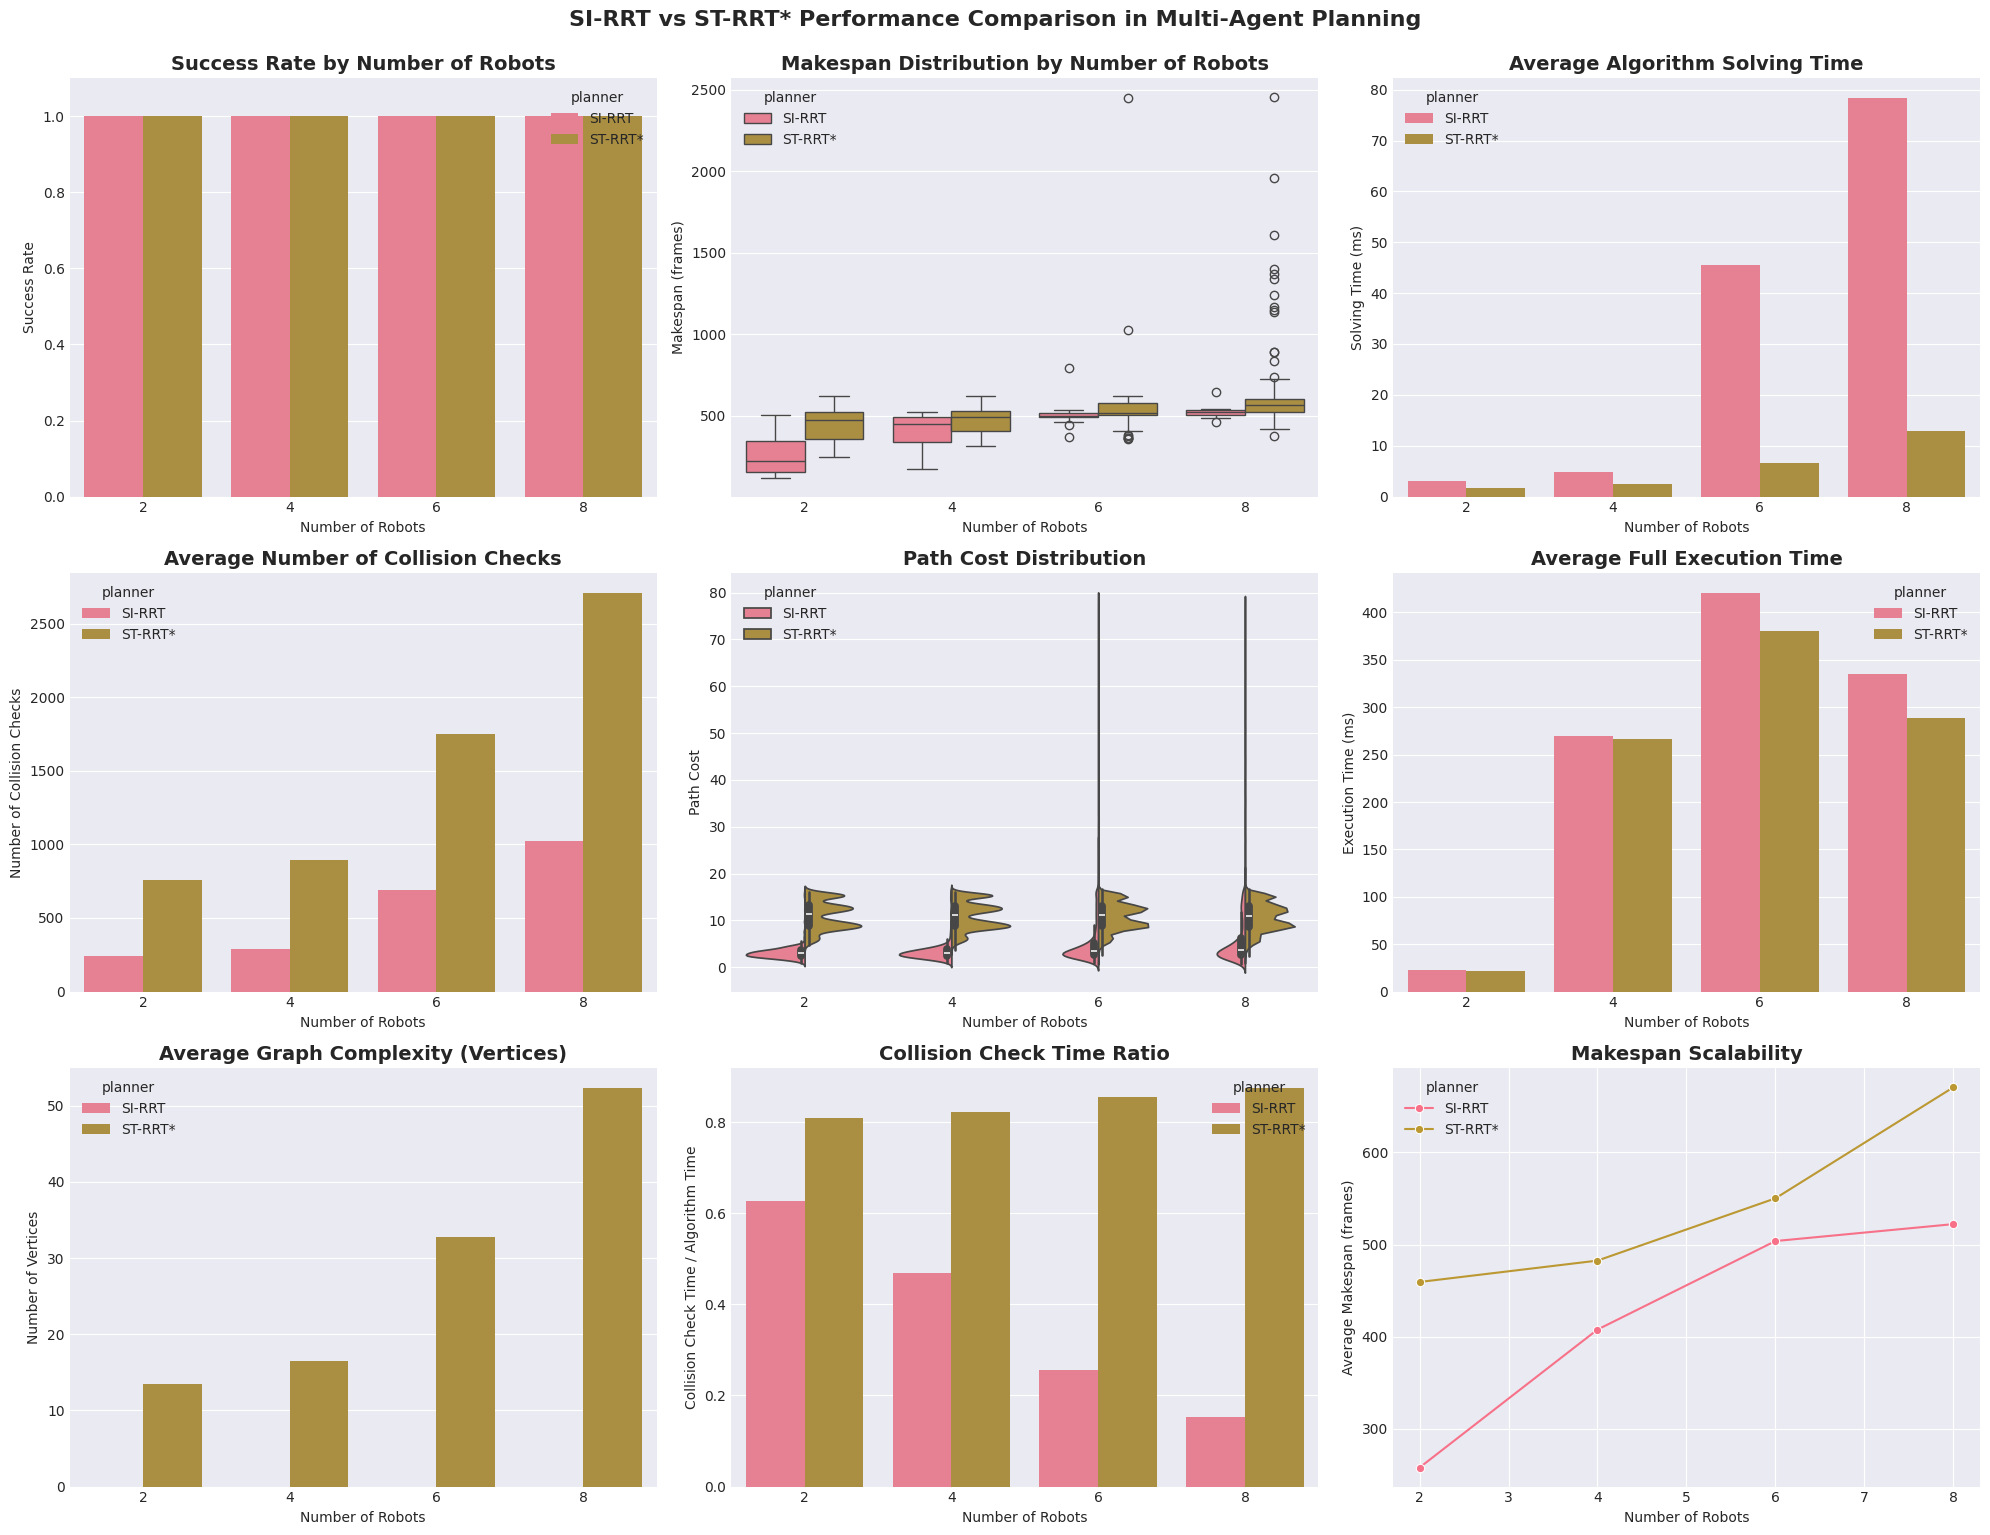

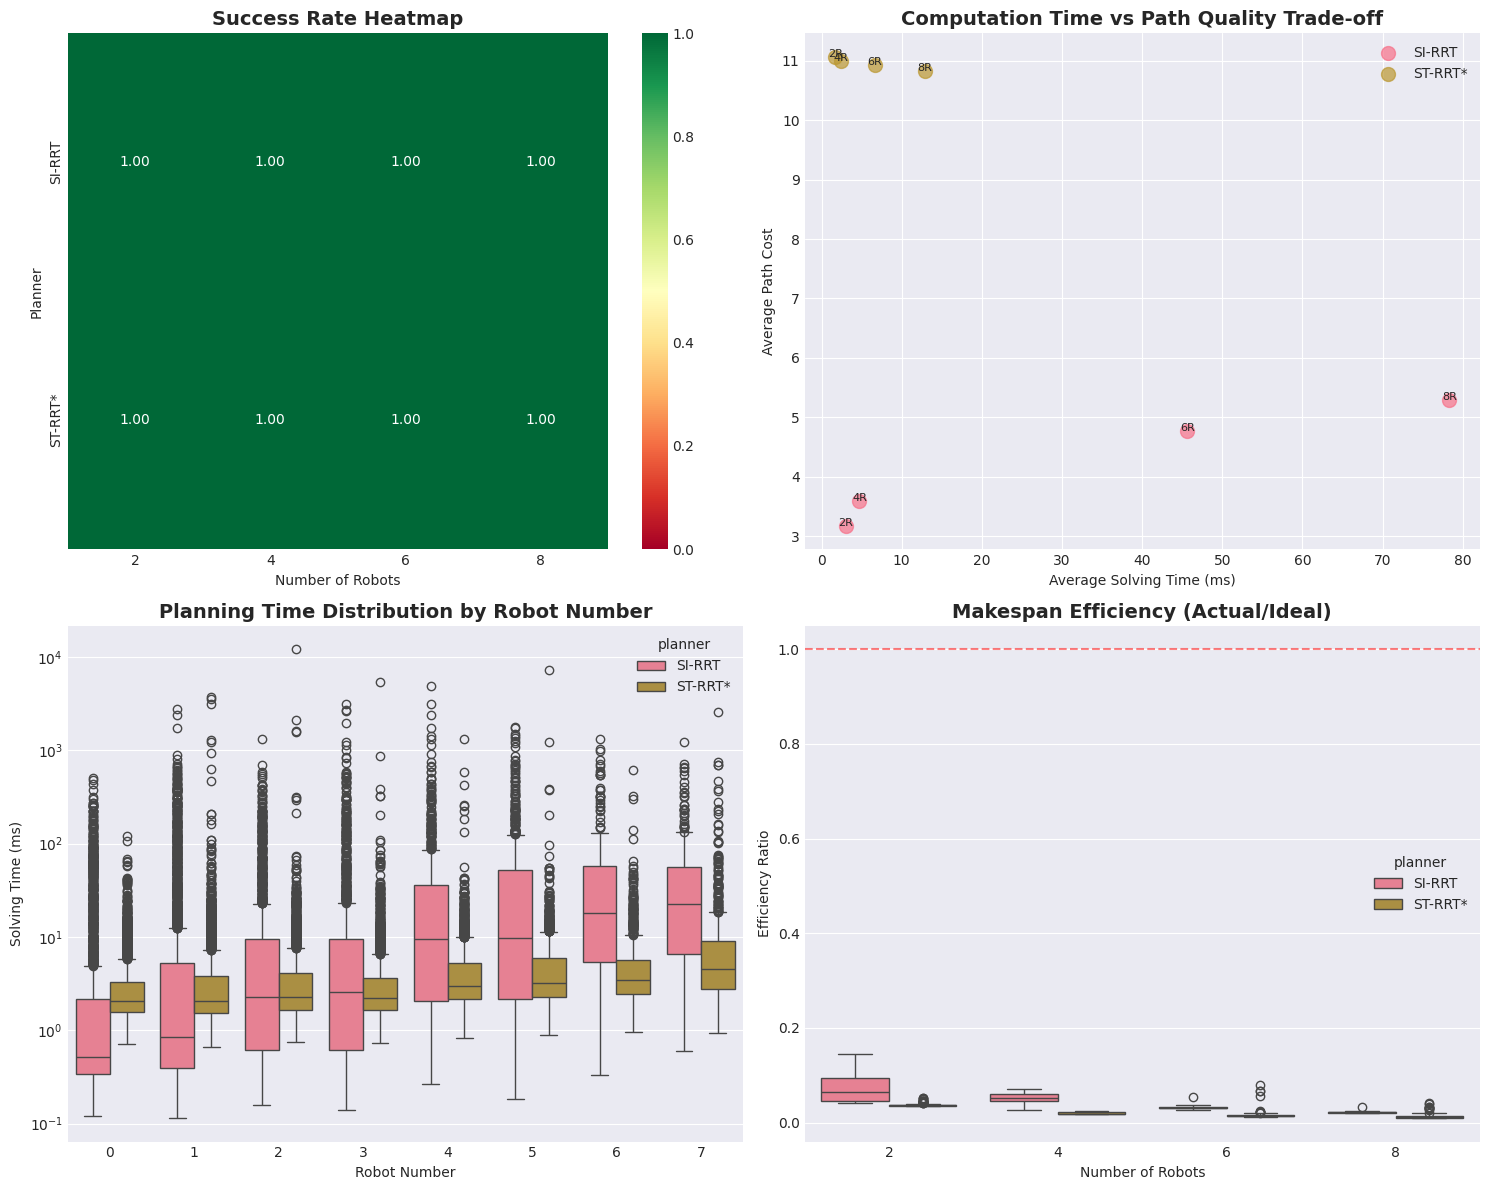

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      1.0
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  2           257.90  120.02
        4           407.71   98.23
        6           503.85   52.47
        8           522.21   35.63
ST-RRT* 2           459.40  103.80
        4           482.61   89.24
        6           550.21  221.08
        8           670.73  338.04


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2              3.00
         4              4.74
         6             45.63
         8             78.32
ST-RRT*  2              1.71
         4              2.42
         6              6.62
         8             12.89
Name: algorithm_solving_time_ns, dtype: fl

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract data from the results
def extract_data(results):
    data = []
    
    for planner_name, planner_results in [('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)]:
        for test_result in planner_results:
            test_id = test_result['test_case_id']
            num_robots = int(test_result['kolvo_robotob'])
            success = test_result['success']
            seed = test_result['seed']
            
            # Extract planning instances data
            for instance in test_result['planning_instances']:
                robot_num = instance['robot_number']
                start_time = instance['start_time']
                
                # Extract metrics from data
                instance_data = instance['data']
                
                data.append({
                    'planner': planner_name,
                    'test_id': test_id,
                    'num_robots': num_robots,
                    'success': success,
                    'seed': seed,
                    'robot_number': robot_num,
                    'start_time': start_time,
                    'has_result': instance_data['final_planner_data']['has_result'],
                    'path_cost': instance_data['final_planner_data'].get('path_cost', np.nan),
                    'algorithm_solving_time_ns': instance_data['algorithm_solving_time_ns'],
                    'collision_check_time_ns': instance_data['collision_check_time_ns'],
                    'number_of_collision_checks': instance_data['number_of_collision_checks'],
                    'full_execution_time_ns': instance_data['full_execution_time_ns'],
                    'number_of_vertices': instance_data['final_planner_data'].get('number_of_vertices', 0),
                    'number_of_edges': instance_data['final_planner_data'].get('number_of_edges', 0)
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = extract_data([('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)])

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('Robot Number')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

sns.boxplot(data=efficiency_df, x='num_robots', y='efficiency', hue='planner', ax=ax4)
ax4.set_title('Makespan Efficiency (Actual/Ideal)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Efficiency Ratio')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Ideal')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

/tmp/ipykernel_670963/1611386964.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()


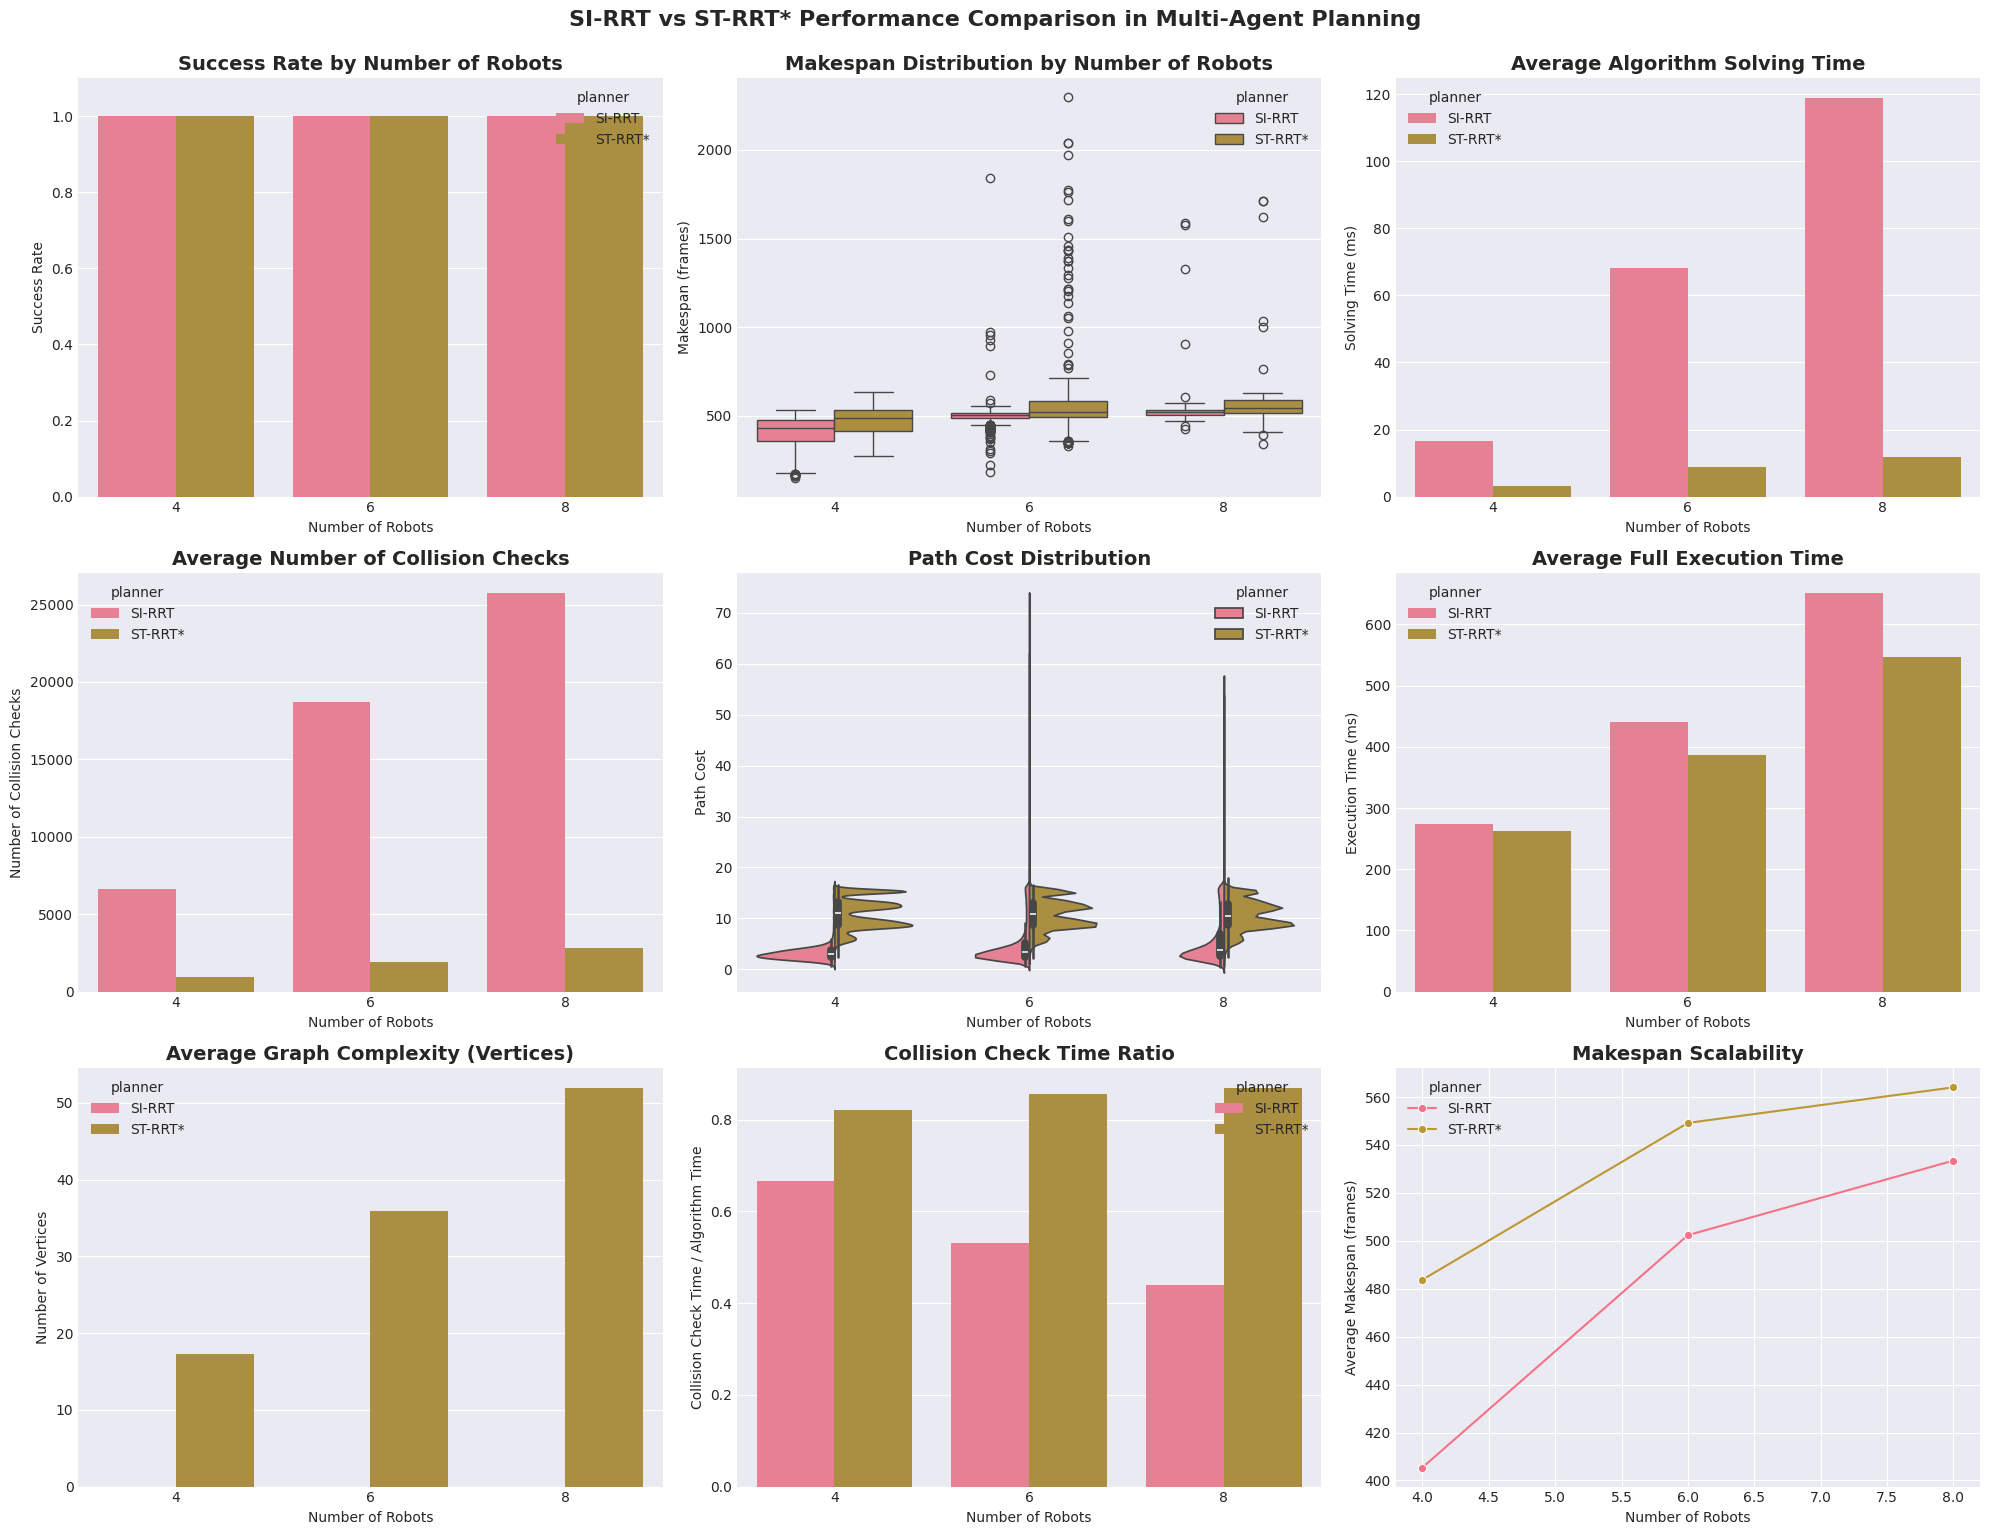

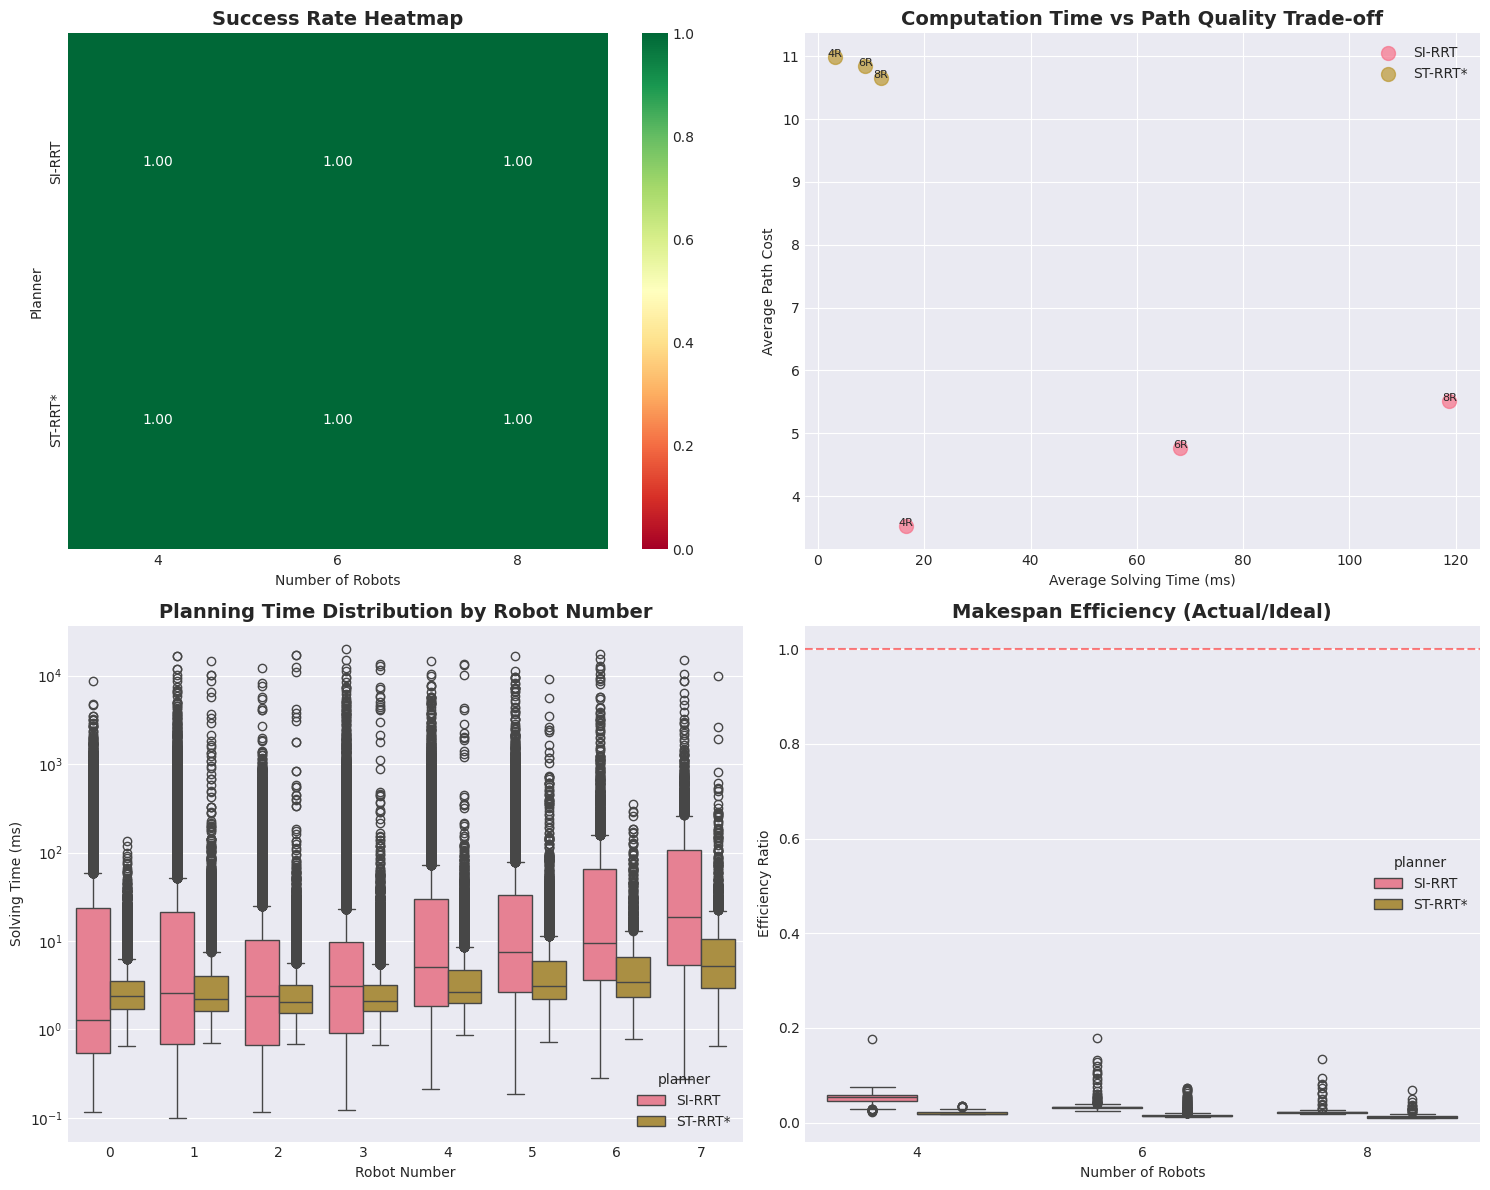

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                      mean     std
planner num_robots                
SI-RRT  4           405.37   87.78
        6           502.35   60.30
        8           533.47  118.88
ST-RRT* 4           483.75   89.38
        6           549.19  182.49
        8           564.04  153.35


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   4              16.62
         6              68.19
         8             118.78
ST-RRT*  4               3.26
         6               8.90
         8              11.84
Name: algorithm_solving_time_ns, dtype: float64


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract data from the results
def extract_data(results):
    data = []
    
    for planner_name, planner_results in [('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)]:
        for test_result in planner_results:
            test_id = test_result['test_case_id']
            num_robots = int(test_result['kolvo_robotob'])
            success = test_result['success']
            seed = test_result['seed']
            
            # Extract planning instances data
            for instance in test_result['planning_instances']:
                robot_num = instance['robot_number']
                start_time = instance['start_time']
                
                # Extract metrics from data
                instance_data = instance['data']
                
                data.append({
                    'planner': planner_name,
                    'test_id': test_id,
                    'num_robots': num_robots,
                    'success': success,
                    'seed': seed,
                    'robot_number': robot_num,
                    'start_time': start_time,
                    'has_result': instance_data['final_planner_data']['has_result'],
                    'path_cost': instance_data['final_planner_data'].get('path_cost', np.nan),
                    'algorithm_solving_time_ns': instance_data['algorithm_solving_time_ns'],
                    'collision_check_time_ns': instance_data['collision_check_time_ns'],
                    'number_of_collision_checks': instance_data['number_of_collision_checks'],
                    'full_execution_time_ns': instance_data['full_execution_time_ns'],
                    'number_of_vertices': instance_data['final_planner_data'].get('number_of_vertices', 0),
                    'number_of_edges': instance_data['final_planner_data'].get('number_of_edges', 0)
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = extract_data([('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)])

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('Robot Number')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

sns.boxplot(data=efficiency_df, x='num_robots', y='efficiency', hue='planner', ax=ax4)
ax4.set_title('Makespan Efficiency (Actual/Ideal)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Efficiency Ratio')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Ideal')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))